In [277]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [278]:
import os
from dotenv import load_dotenv

load_dotenv()

aws_key_id = os.getenv("AWS_ACCESS_KEY_ID")
aws_key_secret = os.getenv("AWS_SECRET_ACCESS_KEY")
s3_endpoint_url = os.getenv("MLFLOW_S3_ENDPOINT_URL")

os.environ['MLFLOW_TRACKING_URI']= os.getenv('MLFLOW_URL')

os.environ["AWS_ACCESS_KEY_ID"] = aws_key_id
os.environ["AWS_SECRET_ACCESS_KEY"] = aws_key_secret
os.environ["MLFLOW_S3_ENDPOINT_URL"] = s3_endpoint_url

In [279]:

import requests

def get_jwt_token(url: str, client_id: str, client_secret: str, username: str, password: str) -> str | None:
    """
    Получает JWT токен с использованием grant_type=password.
    
    :param url: URL для отправки POST-запроса
    :param client_id: ID клиента OAuth2
    :param client_secret: Секрет клиента OAuth2
    :param username: Имя пользователя
    :param password: Пароль пользователя
    :return: JWT токен (access_token) или None в случае ошибки
    """
    data = {
        "grant_type": "password",
        "client_id": client_id,
        "client_secret": client_secret,
        "username": username,
        "password": password,
        "scope": "openid"
    }

    try:
        response = requests.post(url, data=data)
        response.raise_for_status()  # выбросит исключение при ошибке HTTP

        token = response.json().get("access_token")
        if token:
            print(f"JWT Token: {token}")
            return token
        else:
            print("Token not found in response.")
            return None

    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err} - {response.text}")
    except requests.exceptions.RequestException as req_err:
        print(f"Request exception occurred: {req_err}")
    except ValueError as json_err:
        print(f"Error decoding JSON: {json_err}")

    return None


def create_token():
    client_id = os.getenv("OAUTH_CLIENT_ID")
    client_secret = os.getenv("OAUTH_CLIENT_SECRET")
    oauth_endpoint_url = os.getenv("OAUTH_URL")
    username = os.getenv("MLFLOW_USERNAME")
    password = os.getenv("MLFLOW_PASSWORD")

    return get_jwt_token(
        url=oauth_endpoint_url,
        client_id=client_id,
        client_secret=client_secret,
        username=username,
        password=password

    )


## 🧾 Описание датасета IEEE Fraud Detection

Этот датасет был создан в рамках соревнования на Kaggle совместно с компанией **Vesta Corporation**, поставщиком решений для цифровой безопасности.  
**Цель:** спрогнозировать, является ли онлайн-транзакция мошеннической (целевая переменная `isFraud`).

---

## 📁 Структура датасета

### 🔹 Обучающая выборка
- `train_transaction.csv` — данные о транзакциях
- `train_identity.csv` — данные об устройстве, IP, браузере, ОС и пр., используемых во время транзакции

### 🔹 Тестовая выборка
- `test_transaction.csv`
- `test_identity.csv`

Обе таблицы соединяются по колонке `TransactionID`.

---

## 🎯 Целевая переменная
- `isFraud` — бинарный флаг:
  - `1`: транзакция — мошенническая
  - `0`: транзакция — легитимная

---

## 🧩 Признаки

### 📦 Transaction Features

| Признак           | Описание |
|-------------------|----------|
| `TransactionID`   | Уникальный ID транзакции |
| `TransactionDT`   | Временная метка (в секундах от некой базовой точки) |
| `TransactionAMT`  | Сумма транзакции (в долларах США) |
| `ProductCD`       | Код продукта |
| `card1`-`card6`   | Информация о платёжной карте: ID карты, тип, банк, страна и т.д. |
| `addr1`, `addr2`  | Географическая информация (адрес, штат и т.д.) |
| `dist1`, `dist2`  | Расстояние от пользователя до магазина или устройства |
| `P_emaildomain`, `R_emaildomain` | Email-домен покупателя и получателя |
| `C1`–`C14`        | Различные счётчики, связанные с транзакциями (например, кол-во карт, устройств, адресов) |
| `D1`–`D15`        | Временные дельты — количество дней с последней транзакции и т.д. |
| `M1`–`M9`         | Бинарные флаги сопоставления (например, совпадает ли адрес доставки и биллинга) |
| `V1`–`V339`       | Скрытые признаки, созданные системой Vesta (feature engineering) |

---

### 🧠 Identity Features

| Признак           | Описание |
|-------------------|----------|
| `DeviceType`      | Тип устройства (desktop / mobile) |
| `DeviceInfo`      | Информация об устройстве (например, модель или браузер) |
| `id_12`–`id_38`   | Признаки, связанные с IP, прокси, ISP, операционной системой и прочими параметрами пользователя. Их конкретное значение скрыто по соображениям конфиденциальности. |

---

## 🗃 Категориальные признаки

Некоторые из них:

- `ProductCD`
- `card1` – `card6`
- `addr1`, `addr2`
- `P_emaildomain`, `R_emaildomain`
- `M1` – `M9`
- `DeviceType`, `DeviceInfo`
- `id_12` – `id_38`

---

## ⚠ Особенности

- **Сильно несбалансированный датасет:** мошеннические транзакции — лишь малая часть выборки.
- **Псевдовременная метка (`TransactionDT`)** — может использоваться для создания временных признаков.
- **Много пропусков и выбросов** — важно тщательно обрабатывать данные.
- **Скрытые признаки `Vxxx`** — важно использовать отброс шума и методы отбора признаков.

In [280]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Чтобы красиво отображались графики
import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
#plt.style.use("seaborn-dark")

In [281]:
N_TRIALS = 20
EPOCHS = 40

In [282]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    start_mem = df.memory_usage().sum() / 1024**2    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32) # тип float16, который не поддерживается scikit-learn и pandas в некоторых операциях — особенно при масштабировании и индексировании.
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    
    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose: print('Mem. usage decreased to {:5.2f} => {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [283]:
import pandas as pd

def load_and_merge_data(path_transaction, path_identity, reduce_mem_usage_func):
    # Загрузка данных
    transaction = pd.read_csv(path_transaction)
    identity = pd.read_csv(path_identity)
    print(f"Размер train_transaction: {transaction.shape}")
    print(f"Размер train_identity: {identity.shape}")

    # Уменьшение памяти
    transaction = reduce_mem_usage_func(transaction)
    identity = reduce_mem_usage_func(identity)

    # Объединение по TransactionID
    train = transaction.merge(identity, how='left', on='TransactionID')
    print(f"Итоговый размер train: {train.shape}")

    return train

In [284]:
def check_column_consistency(train, test, target_column='isFraud'):
    """
    Проверяет совпадение названий столбцов между обучающей и тестовой выборками.

    Аргументы:
        train (pd.DataFrame): обучающий набор данных
        test (pd.DataFrame): тестовый набор данных
        target_column (str): название целевого столбца (по умолчанию 'isFraud')

    Возвращает:
        train_only_cols (set): столбцы только в train
        test_only_cols (set): столбцы только в test
    """
    print('Проверка совпадения колонок между train и test...')
    train_cols = set(train.columns)
    test_cols = set(test.columns)
    train_only_cols = train_cols - test_cols
    test_only_cols = test_cols - train_cols

    if train_only_cols:
        print(f"Внимание: в train есть {len(train_only_cols)} колонок, которых нет в test:")
        print(sorted(train_only_cols))
    else:
        print("В train нет лишних колонок.")

    if test_only_cols:
        print(f"Внимание: в test есть {len(test_only_cols)} колонок, которых нет в train:")
        print(sorted(test_only_cols))
    else:
        print("В test нет лишних колонок.")

    common_cols = train_cols & test_cols
    common_ratio = len(common_cols) / max(len(train_cols), len(test_cols))
    print(f"Доля пересекающихся колонок: {common_ratio:.2%}")

    if target_column in train_only_cols:
        print(f"Проверка: целевой столбец '{target_column}' есть только в train (ожидаемо)")

    print("Проверка колонок завершена.")
    return train_only_cols, test_only_cols

In [285]:
def unify_column_names(df, from_char='-', to_char='_'):
    """
    Заменяет символ from_char на to_char во всех названиях столбцов датафрейма.

    Аргументы:
        df (pd.DataFrame): датафрейм, в котором требуется унифицировать имена столбцов
        from_char (str): символ, который нужно заменить (по умолчанию '-')
        to_char (str): символ, на который заменяем (по умолчанию '_')

    Возвращает:
        pd.DataFrame: копия датафрейма с обновлёнными именами столбцов
    """
    df = df.copy()
    df.columns = [col.replace(from_char, to_char) for col in df.columns]
    return df

In [286]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, threshold=None, labels=None, title="Confusion Matrix"):
    """
    Строит confusion matrix и её heatmap-график.
    y_true — истинные метки (array-like)
    y_pred — предсказанные метки (array-like)
    labels — порядок классов для осей (например, [0, 1])
    """
    if threshold is not None:
        # применить порог к вероятностям
        y_pred = (y_pred >= threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)
    plt.show()

In [287]:
def plot_feature_correlation_matrix(X, y=None, target_name='target', figsize=(12,10), annot=False):
    """
    Строит и визуализирует корреляционную матрицу, включая target, если задан.
    X — DataFrame с признаками.
    y — Series/array с целевой переменной (если надо добавить в матрицу).
    """
    if y is not None:
        X = X.copy()
        X[target_name] = y
    corr = X.corr()
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=annot, fmt=".2f", cmap='coolwarm', cbar=True)
    plt.title("Feature Correlation Matrix" + (f" (+{target_name})" if y is not None else ''))
    plt.show()
    return corr

In [288]:

def analyse_folds(X, y, cv):
    # Проверка распределения
    fold_idx = 1
    for train_index, test_index in cv.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]


        print(f"Fold {fold_idx}")
        print("Train class distribution:", Counter(y_train_fold))
        print("Test class distribution:", Counter(y_test_fold))

        # Визуализация
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(y_train_fold, kde=False, bins=3).set_title(f'Fold {fold_idx} - Train')
        plt.subplot(1, 2, 2)
        sns.histplot(y_test_fold, kde=False, bins=3).set_title(f'Fold {fold_idx} - Test')
        plt.show()

        fold_idx += 1

In [289]:
# Импортируем библиотеки
import pandas as pd
import numpy as np

# Путь к данным /kaggle/input/ieee-fraud-detection
BASE = '/kaggle/input/ieee-fraud-detection'
BASE = '../data/raw/ieee-fraud-detection'

In [290]:
PATH_TRANSACTION_TRAIN = f'{BASE}/train_transaction.csv'
PATH_IDENTITY_TRAIN = f'{BASE}/train_identity.csv'

train = load_and_merge_data(PATH_TRANSACTION_TRAIN, PATH_IDENTITY_TRAIN, reduce_mem_usage)
train.head()

Размер train_transaction: (590540, 394)
Размер train_identity: (144233, 41)
Mem. usage decreased to 1775.15 => 916.30 Mb (48.4% reduction)
Mem. usage decreased to 45.12 => 31.91 Mb (29.3% reduction)
Итоговый размер train: (590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [291]:
PATH_TRANSACTION_TEST = f'{BASE}/test_transaction.csv'
PATH_IDENTITY_TEST = f'{BASE}/test_identity.csv'

test = load_and_merge_data(PATH_TRANSACTION_TEST, PATH_IDENTITY_TEST, reduce_mem_usage)
test.head()

Размер train_transaction: (506691, 393)
Размер train_identity: (141907, 41)
Mem. usage decreased to 1519.24 => 785.71 Mb (48.3% reduction)
Mem. usage decreased to 44.39 => 31.40 Mb (29.3% reduction)
Итоговый размер train: (506691, 433)


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.950001,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950012,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.949997,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [292]:
check_column_consistency(train, test)

Проверка совпадения колонок между train и test...
Внимание: в train есть 39 колонок, которых нет в test:
['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'isFraud']
Внимание: в test есть 38 колонок, которых нет в train:
['id-01', 'id-02', 'id-03', 'id-04', 'id-05', 'id-06', 'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12', 'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19', 'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26', 'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
Доля пересекающихся колонок: 91.01%
Проверка: целевой столбец 'isFraud' есть только в train (ожидаемо)
Проверка колонок завершена.


({'id_01',
  'id_02',
  'id_03',
  'id_04',
  'id_05',
  'id_06',
  'id_07',
  'id_08',
  'id_09',
  'id_10',
  'id_11',
  'id_12',
  'id_13',
  'id_14',
  'id_15',
  'id_16',
  'id_17',
  'id_18',
  'id_19',
  'id_20',
  'id_21',
  'id_22',
  'id_23',
  'id_24',
  'id_25',
  'id_26',
  'id_27',
  'id_28',
  'id_29',
  'id_30',
  'id_31',
  'id_32',
  'id_33',
  'id_34',
  'id_35',
  'id_36',
  'id_37',
  'id_38',
  'isFraud'},
 {'id-01',
  'id-02',
  'id-03',
  'id-04',
  'id-05',
  'id-06',
  'id-07',
  'id-08',
  'id-09',
  'id-10',
  'id-11',
  'id-12',
  'id-13',
  'id-14',
  'id-15',
  'id-16',
  'id-17',
  'id-18',
  'id-19',
  'id-20',
  'id-21',
  'id-22',
  'id-23',
  'id-24',
  'id-25',
  'id-26',
  'id-27',
  'id-28',
  'id-29',
  'id-30',
  'id-31',
  'id-32',
  'id-33',
  'id-34',
  'id-35',
  'id-36',
  'id-37',
  'id-38'})

In [293]:
train = unify_column_names(train)
test = unify_column_names(test)

In [294]:
check_column_consistency(train, test)

Проверка совпадения колонок между train и test...
Внимание: в train есть 1 колонок, которых нет в test:
['isFraud']
В test нет лишних колонок.
Доля пересекающихся колонок: 99.77%
Проверка: целевой столбец 'isFraud' есть только в train (ожидаемо)
Проверка колонок завершена.


({'isFraud'}, set())

In [398]:
train.to_csv('../data/raw/ieee-fraud-detection/test_transactions.csv', index=False)

# 1. Обзор исходных данных (EDA)

In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [296]:
df = train.copy()

## 1.1 Структура данных

Данный шаг нужен для **быстрой первичной разведки (осмотра)** датафрейма `df` после загрузки данных.  
Вот что делает каждая команда:

---

### 1. `df.shape`
- Возвращает кортеж из двух чисел:  
  (число строк, число столбцов) в таблице.
- Это позволяет сразу понять **размерность** набора данных: сколько “объектов” и сколько “признаков”.

---

### 2. `df.dtypes`
- Показывает **тип данных** каждого столбца (integer, float, object, datetimelike, и т.д.).
- Это важно для понимания, какие признаки можно анализировать как числа, какие — как текст или дату, и требуется ли преобразование типов.

---

### 3. `df.head()`
- Показывает **первые 5 строк** датафрейма, то есть “голову” таблицы.
- Можно быстро оценить структуру данных, наличие явных ошибок/пропусков, примерные значения (например, как выглядят id, цены, метки и т.д.).

---
**Это минимальный обзор для знакомства с любым новым датасетом перед анализом!**

In [297]:
df.shape

(590540, 434)

In [298]:
df.dtypes

TransactionID       int32
isFraud              int8
TransactionDT       int32
TransactionAmt    float32
ProductCD          object
                   ...   
id_36              object
id_37              object
id_38              object
DeviceType         object
DeviceInfo         object
Length: 434, dtype: object

In [299]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## 1.2 Пропуски

Этот шан нужен для **анализа пропущенных значений** в данных. Он помогает быстро определить, в каких столбцах датафрейма `df` пропусков (NaN) больше всего.

---

### Что делает каждая строка кода:

1.  
```python
missing_col = df.isnull().mean().sort_values(ascending=False)
```
- `df.isnull()` возвращает таблицу такого же размера, где для каждого элемента написано `True`, если он пропущен (NaN), и `False` — если нет.
- `.mean()` по умолчанию считается по каждому столбцу:  
  - Для булевых значений `True` считается как 1, `False` — как 0,  
  - Получается **доля пропущенных значений** (от 0 до 1) для каждого столбца.
- `.sort_values(ascending=False)` — сортирует столбцы по убыванию: наверху окажутся те, где больше всего пропусков.

2.  
```python
missing_col.head(10)
```
- Показывает **топ-10 столбцов с наибольшей долей пропусков**.

---

### **Зачем нужен этот анализ:**

- Быстро узнать, **где больше всего отсутствующих данных**.
- Оценить, какие признаки требуют особой обработки:  
  - может быть удалены,
  - возможно, требуют специальных стратегий заполнения (имьютации),
  - или проанализировать, почему там так много пропусков (особенность домена или ошибочная выгрузка).
- Помогает принять решения на этапе препроцессинга, чтобы не навредить последующей модели.

---

Этот код находит и выводит 10 признаков, в которых больше всего пропущенных значений (и насколько их там много, в долях от общего количества строк).  
Это необходимый шаг для грамотной очистки и подготовки данных.

In [300]:
missing_col = df.isnull().mean().sort_values(ascending=False)
missing_col.head(10)

id_24    0.991962
id_25    0.991310
id_07    0.991271
id_08    0.991271
id_21    0.991264
id_26    0.991257
id_27    0.991247
id_23    0.991247
id_22    0.991247
dist2    0.936284
dtype: float64

## Таргет

In [301]:
summary = (df['isFraud']
   .value_counts()
   .to_frame('count')
)
summary['share(%)'] = 100 * summary['count'] / summary['count'].sum()
print(summary)

          count   share(%)
isFraud                   
0        569877  96.500999
1         20663   3.499001


## Категориальные признаки

Этот шаг служит для **первичного анализа категориальных признаков** в датафрейме `df`.

---

### Что делает код по шагам:

1.  
```python
cat_cols = df.select_dtypes(include=['object', 'category']).columns
```
- Находит все столбцы с типом данных `object` или `category`, т.е. категориальные (текстовые, строковые, перечислимые) признаки.

2.  
```python
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique; most common: {df[col].value_counts(dropna=False).head()}\n")
```
- Для **каждого категориального признака**:
  - Печатает его название.
  - Считает и показывает количество уникальных значений (`nunique()`).
  - Показывает топ-5 наиболее часто встречающихся значений (и их частоты) с помощью `value_counts().head()`. Параметр `dropna=False` гарантирует, что будут учтены даже пропуски (NaN).

---

### **Зачем нужен этот анализ:**

- **Понять, какие признаки категориальные.**
- **Оценить их кардинальность:**  
  (сколько уникальных значений — например, 2, 10, 1000? Это сильно влияет на выбор способа кодирования)
- **Посмотреть на лидирующие значения:**  
  (чтобы понять, сбалансирован ли признак, не доминирует ли одно значение; а также учесть редкие варианты)
- **Видеть случаи, когда есть пропуски как отдельное "значение" в категориальных колонках.**

---

### **Почему важно:**

- Если уникальных значений очень много, например, тысячи и больше, — простое OneHotEncoding приведёт к огромному количеству новых признаков (и может быть неоптимально).
- Анализ помогает принять решение:  
  — Как кодировать (Label/OneHot/Target/Count Encoding)  
  — Нужно ли объединить редкие категории, как обрабатывать пропуски, и т.д.

---

“быстрый обзор” категориальных признаков: сколько у них уникальных значений и какие встречаются чаще всего. Это необходимый шаг для понимания структуры данных и планирования дальнейшего feature engineering.

In [302]:
cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique; most common: {df[col].value_counts(dropna=False).head()}\n")


ProductCD: 5 unique; most common: ProductCD
W    439670
C     68519
R     37699
H     33024
S     11628
Name: count, dtype: int64

card4: 4 unique; most common: card4
visa                384767
mastercard          189217
american express      8328
discover              6651
NaN                   1577
Name: count, dtype: int64

card6: 4 unique; most common: card6
debit              439938
credit             148986
NaN                  1571
debit or credit        30
charge card            15
Name: count, dtype: int64

P_emaildomain: 59 unique; most common: P_emaildomain
gmail.com        228355
yahoo.com        100934
NaN               94456
hotmail.com       45250
anonymous.com     36998
Name: count, dtype: int64

R_emaildomain: 60 unique; most common: R_emaildomain
NaN              453249
gmail.com         57147
hotmail.com       27509
anonymous.com     20529
yahoo.com         11842
Name: count, dtype: int64

M1: 2 unique; most common: M1
T      319415
NaN    271100
F          25
Name: 

## 1.3 Числовые признаки

Этот код выводит **статистическое описание всех числовых признаков** датасета `df` в виде таблицы (транспонированной для удобного чтения).

---

- `num_cols = df.select_dtypes(include='number').columns`  
  — выбирает все столбцы типа “число” (например: float, int), т.е. только числовые признаки.

- `df[num_cols].describe()`  
  — считает основные статистики (по каждому из этих столбцов):
    - **count** — количество непустых значений,
    - **mean** — среднее,
    - **std** — стандартное отклонение,
    - **min** — минимум,
    - **25%** — 1-й квартиль,
    - **50%** — медиана,
    - **75%** — 3-й квартиль,
    - **max** — максимум.

- `.T`  
  — транспонирует таблицу: строки становятся столбцами, и наоборот.  
  Теперь каждая строка — это отдельный признак, а столбцы — его статистики.

---

- Для **каждого числового признака**:
    - сколько пропущенных/непропущенных значений,
    - среднее и медиану,
    - разброс (стандартное отклонение),
    - минимальные и максимальные значения,
    - квартили (распределение внутри признака).

---

### **Для чего это используют:**

- **Быстро увидеть выбросы** (max сильно выше 75% или min сильно ниже 25%).
- **Найти признаки с несбалансированным распределением** (где среднее ≠ медиане).
- **Оценить наличие пропущенных значений** (count < всего строк).
- **Понять масштаб и роли признаков** для последующей обработки (например, надо ли логарифмировать или нормализовать).

---

Видим сводную таблицу с основными статистиками по **всем числовым признакам** датасета.

In [303]:
num_cols = df.select_dtypes(include='number').columns
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2987000.000,3.134635e+06,3.282270e+06,3429904.25,3.577539e+06
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000000e+00,0.000000e+00,0.00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3.027058e+06,7.306528e+06,11246620.00,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,4.332100e+01,6.876900e+01,125.00,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6.019000e+03,9.678000e+03,14184.00,1.839600e+04
...,...,...,...,...,...,...,...,...
id_22,5169.0,1.600271e+01,6.897665e+00,10.000,1.400000e+01,1.400000e+01,14.00,4.400000e+01
id_24,4747.0,1.280093e+01,2.372447e+00,11.000,1.100000e+01,1.100000e+01,15.00,2.600000e+01
id_25,5132.0,3.296089e+02,9.746109e+01,100.000,3.210000e+02,3.210000e+02,371.00,5.480000e+02
id_26,5163.0,1.490703e+02,3.210199e+01,100.000,1.190000e+02,1.490000e+02,169.00,2.160000e+02


## 1.4 Временная структура

Этот график показывает **распределение количества транзакций по значению признака `TransactionDT`**.


- `TransactionDT` — это числовой признак, отражающий количество секунд с некоторого начального момента (“начала сбора данных”).
- `plt.hist(ts, bins=100)` строит гистограмму (разбивает данные на 100 диапазонов/интервалов и считает, сколько транзакций попадает в каждый такой промежуток).
- Ось X: значения `TransactionDT` (временная шкала или счётчик).
- Ось Y: количество транзакций в каждом сегменте времени.

 
Этот график визуализирует время сбора транзакций — когда их было больше, когда меньше — и помогает понять, как распределены данные по времени.

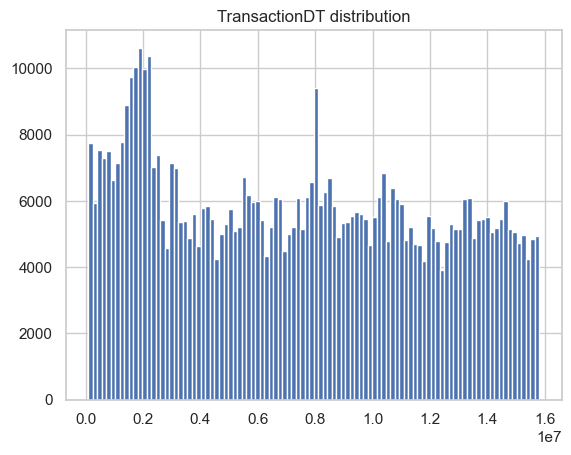

In [304]:

ts = df["TransactionDT"]
plt.hist(ts, bins=100)
plt.title("TransactionDT distribution")
plt.show()

## 1.5 Признаки V

Этот график — **тепловая карта (heatmap)** модуля корреляций между всеми признаками, которые начинаются с "V" в датафрейме.

---

- `v_cols = [col for col in df.columns if col.startswith('V')]`  
  — выбирает все столбцы, имена которых начинаются с "V" (например, V1, V2, ..., V300). Это скрытые ("technical") признаки после какой-то анонимизации или специальной обработки.

- `corr = df[v_cols].corr().abs()`  
  — вычисляет матрицу корреляций между всеми этими V-признаками, и берёт абсолютное значение.

- `sns.heatmap(corr, cmap='coolwarm')`  
  — строит тепловую карту (heatmap):  
    - Ось X — признаки V1, V2, ...,  
    - Ось Y — признаки V1, V2, ...,  
    - Цвет клетки — степень корреляции между парой признаков (от 0 — нет связи, до 1 — полная линейная зависимость).

---

### **Что позволяет увидеть этот график?**

- **Группы сильно коррелирующих между собой признаков** (большие плотные яркие квадраты). Это значит, что V-фичи внутри группы схожи между собой и, возможно, избыточны (могут быть заменены друг на друга или агрегированы).
- **Почти независимые признаки** (светлые/белые области вне главной диагонали), которые содержат уникальную информацию.
- **Для дальнейшей работы:**  
    - Высоко коррелирующие признаки часто превращают в несколько агрегированных с помощью PCA или оставляют только один признак из группы, чтобы снизить размерность и избежать мультиколлинеарности.

---

Этот график показывает, как сильно связаны между собой технические признаки V1..Vxxx — есть ли среди них дубли или группы похожих признаков, которые можно агрегировать или удалить для оптимизации модели.

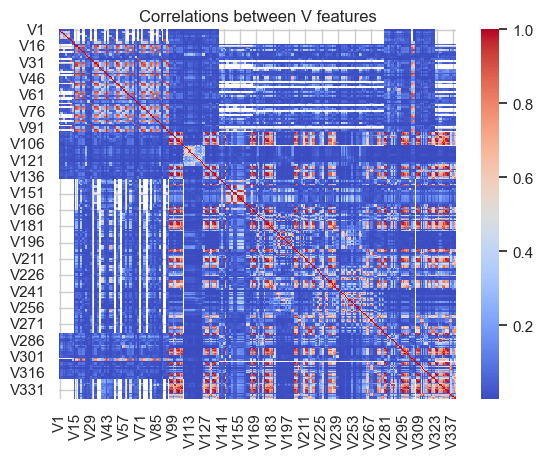

In [305]:
v_cols = [col for col in df.columns if col.startswith('V')]
corr = df[v_cols].corr().abs()
sns.heatmap(corr, cmap='coolwarm')
plt.title("Correlations between V features")
plt.show()

## 1.6 KFolds

In [306]:
#from sklearn.model_selection import TimeSeriesSplit


#tscv = TimeSeriesSplit(n_splits=5)
#analyse_folds(X_train, y_train, tscv)

 # 2. Preprocessing и Feature Engineering

## 2.1 Обработка пропусков

Цель:

- Удалить признаки (столбцы) и строки, где слишком много пропусков, потому что на них нельзя рассчитывать для построения модели.
- Избавиться от лишнего шума и потенциально нерелевантных фичей, чтобы сфокусироваться на данных, которые доступны и могут быть информативными.

In [307]:
# Удалим сильно пропущенные колонки:
drop_col_threshold = 0.3
to_drop = df.columns[df.isnull().mean() > drop_col_threshold].tolist()
df = df.drop(columns=to_drop)

# Удалим строки с множественными пропусками:
drop_row_threshold = 0.5
row_mask = df.isnull().mean(axis=1) <= drop_row_threshold
df = df.loc[row_mask]

## 2.2 Обработка числовых признаков

Цель:

- Заполнить пропущенные значения, чтобы не терять данные и не допустить ошибку в работе моделей.
- Обычно используется медиана, потому что она устойчивее к выбросам, чем среднее.

In [308]:
num_cols = df.select_dtypes(include='number').columns
for col in num_cols:
    median = df[col].median()
    df[col] = df[col].fillna(median)

df[num_cols].head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,13926,361.0,150.0,142.0,315.0,87.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.3 Категориальные признаки: Label Encoding + Count Encoding

Цель:

- Преобразовать категориальные признаки в числовой вид, чтобы их могла понимать ML-модель (большинство алгоритмов не работают с текстом).
- Label Encoding задает уникальный номер каждому значению, Count Encoding добавляет информацию о "популярности" значения (частоте), что может быть полезно для выявления редких/типичных пользователей по их признакам.

In [309]:
from sklearn.preprocessing import LabelEncoder

cat_cols = df.select_dtypes(include=['object', 'category']).columns
# Заполняем пропуски, если есть
for col in cat_cols:
    df[col] = df[col].astype(str).fillna('unknown')
    # Count encoding (частота значения)
    df[f"{col}_count"] = df[col].map(df[col].value_counts())
    # Label encoding
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


df[cat_cols].head()

,ProductCD,card4,card6,P_emaildomain,M6
0,4,1,1,32,1
1,4,2,1,16,1
2,4,4,2,36,0
3,4,2,2,54,0
4,1,2,1,16,2


## 2.4 Генерация временных признаков

Цель:

- Из временной метки (TransactionDT) извлечь полезные структурные фичи: день, час, день недели и т.д.
- Мошеннические транзакции часто бывают в определённые периоды (ночью, в начале месяца и пр.) — это помогает модели "замечать" такие паттерны.

In [310]:
min_dt = df['TransactionDT'].min()
rel_trx = df['TransactionDT'] - min_dt
df['Relative_TransactionDT'] = rel_trx
df['Transaction_day'] = (rel_trx // (24 * 60 * 60)).astype(int)
df['Transaction_hour'] = ((rel_trx // 3600) % 24).astype(int)
df['Transaction_weekday'] = ((rel_trx // (3600*24)) % 7).astype(int)

df[['TransactionDT', 'Relative_TransactionDT', 'Transaction_day', 'Transaction_hour', 'Transaction_weekday']].head()

,TransactionDT,Relative_TransactionDT,Transaction_day,Transaction_hour,Transaction_weekday
0,86400,0,0,0,0
1,86401,1,0,0,0
2,86469,69,0,0,0
3,86499,99,0,0,0
4,86506,106,0,0,0


## 2.5 TransactionAmt: логарифм, выбросы, бинирование

Цель:

- Преобразовать сумму транзакции — логарифмировать, чтобы уменьшить дисбаланс между маленькими и большими суммами.
- Отметить выбросы — часто мошенники работают с аномальными суммами.
Разбить суммы на бины (Low, Medium, High…) — показать модели "уровень" транзакции как категорию.

In [311]:

amt = df['TransactionAmt']
q1 = amt.quantile(0.25)
q3 = amt.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
df['log_TransactionAmt'] = np.log1p(df['TransactionAmt'])
df['isOutlier'] = ((amt < lower) | (amt > upper)).astype(int)
df['TransactionAmt_binned'] = pd.cut(
    amt, bins=[0, 100, 1000, 5000, 10000, np.inf],
    labels=['Low', 'Medium', 'High', 'Very High', 'Extremely High']
).astype(str).fillna('unknown')
le_amt = LabelEncoder()
df['TransactionAmt_binned'] = le_amt.fit_transform(df['TransactionAmt_binned'])


df[['TransactionAmt', 'log_TransactionAmt', 'isOutlier', 'TransactionAmt_binned']].head()

,TransactionAmt,log_TransactionAmt,isOutlier,TransactionAmt_binned
0,68.5,4.241327,0,2
1,29.0,3.401197,0,2
2,59.0,4.094345,0,2
3,50.0,3.931826,0,2
4,50.0,3.931826,0,2


## 2.6 Групповые признаки (по card1/card4)

Цель:

- Учесть индивидуальные особенности групп (например, "обычная" сумма для этой карты).
- Соотношение суммы транзакции к среднему или стандартному отклонению по пользователю/карте помогает модели выявлять подозрительные (нестандартные) операции именно для данной группы.

In [312]:
for col in ['card1', 'card4']:
    if col in df.columns and 'TransactionAmt' in df.columns:
        group_mean = df.groupby(col)['TransactionAmt'].transform('mean')
        group_std = df.groupby(col)['TransactionAmt'].transform('std').replace(0, 1)
        df[f'TransactionAmt_to_mean_{col}'] = df['TransactionAmt'] / group_mean
        df[f'TransactionAmt_to_std_{col}'] = df['TransactionAmt'] / group_std

group_cols = []
for col in ['card1', 'card4']:
    group_cols.append(f'TransactionAmt_to_mean_{col}')
    group_cols.append(f'TransactionAmt_to_std_{col}')

df[group_cols].head()

,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4
0,0.194640,0.184566,0.257761,0.170233
1,0.123777,0.062995,0.219048,0.114209
2,0.608150,0.589241,0.443066,0.258543
3,0.405133,0.259447,0.377669,0.196913
4,0.515612,0.882933,0.377669,0.196913


## 2.7 Масштабирование числовых признаков

Цель:

- Привести все числовые признаки к одному масштабу (среднее = 0, std = 1), чтобы, например, сумма и возраст "весили" одинаково для моделей, особенно если используете методы, чувствительные к масштабу (логистическая регрессия, SVM, нейронки).

In [313]:
from sklearn.preprocessing import StandardScaler

scale_cols = [col for col in df.select_dtypes(include='number').columns if col not in ['isFraud', 'TransactionID', 'TransactionDT']]
scaler = StandardScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

df[scale_cols].head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,Transaction_day,Transaction_hour,Transaction_weekday,log_TransactionAmt,isOutlier,TransactionAmt_binned,TransactionAmt_to_mean_card1,TransactionAmt_to_std_card1,TransactionAmt_to_mean_card4,TransactionAmt_to_std_card4
0,-0.278173,0.547227,0.821695,-0.009777,-0.281401,-2.187853,-1.396410,-1.675145,0.243320,0.069822,...,-1.566859,-1.822202,-1.455214,-0.151146,-0.356181,-0.699039,-0.589479,-0.077407,-0.418965,-0.400127
1,-0.443331,0.547227,-1.457555,0.264816,-0.281401,-1.222475,-2.368295,-1.675145,0.347541,0.069822,...,-1.566859,-1.822202,-1.455214,-1.047592,-0.356181,-0.699039,-0.641347,-0.085383,-0.440816,-0.456027
2,-0.317894,0.547227,-1.068261,0.814002,-0.281401,0.708281,-0.813279,0.549361,0.399651,0.069822,...,-1.566859,-1.822202,-1.455214,-0.307981,-0.356181,-0.699039,-0.286812,-0.050860,-0.314367,-0.312011
3,-0.355525,0.547227,1.679856,1.305715,-0.281401,-1.222475,-2.003838,0.549361,1.921273,0.069822,...,-1.566859,-1.822202,-1.455214,-0.481394,-0.356181,-0.699039,-0.435410,-0.072495,-0.351281,-0.373506
4,-0.355525,-1.559714,-1.102130,0.967264,-0.281401,-1.222475,-2.368295,-1.675145,1.337637,0.069822,...,-1.566859,-1.822202,-1.455214,-0.481394,-0.356181,-0.699039,-0.354545,-0.031594,-0.351281,-0.373506


## 2.8 PCA для V-фичей

Цель:

- Снизить размерность большого блока технических/скрытых признаков (V1, V2,...,Vxxx), чтобы:
уменьшить "шум",
- избавиться от мультиколлинеарности,
- ускорить работу модели,
- сохранить максимум информации в первой десятке новых признаков ("PCA-компоненты").

In [314]:
from sklearn.decomposition import PCA

v_cols = [col for col in df.columns if col.startswith('V')]
if v_cols:
    X_v = df[v_cols].fillna(-999)
    v_scaler = StandardScaler()
    X_v_scaled = v_scaler.fit_transform(X_v)
    pca = PCA(n_components=0.90, random_state=42)
    X_v_pca = pca.fit_transform(X_v_scaled)
    for i in range(X_v_pca.shape[1]):
        df[f'V_PCA_{i}'] = X_v_pca[:, i]
    df = df.drop(columns=v_cols)


v_cols = [col for col in df.columns if col.startswith('V')]
df[v_cols].head()

,V_PCA_0,V_PCA_1,V_PCA_2,V_PCA_3,V_PCA_4,V_PCA_5,V_PCA_6,V_PCA_7,V_PCA_8,V_PCA_9,...,V_PCA_29,V_PCA_30,V_PCA_31,V_PCA_32,V_PCA_33,V_PCA_34,V_PCA_35,V_PCA_36,V_PCA_37,V_PCA_38
0,-2.433508,0.152228,-0.200233,-1.208503,-2.202788,-0.025086,0.533908,0.067477,0.251205,1.034315,...,-0.443450,0.190290,0.505811,-0.096082,0.570254,-0.125918,0.187061,-0.428733,0.055893,0.241135
1,-1.073074,-0.403067,-0.772776,0.360898,-1.242340,-0.708699,-0.465681,-0.759718,-1.496100,-3.455471,...,0.023931,-0.132636,0.134970,-0.140045,0.002323,0.082141,-0.079385,-0.300280,-0.008055,-0.202973
2,-2.309711,0.067902,-0.090359,-1.478187,-2.119248,0.869249,-0.418507,-0.186059,-0.436880,0.287860,...,-0.664460,-0.119685,0.229102,-0.107414,0.138989,0.187026,0.009011,-0.322280,-0.011132,0.120640
3,-1.569182,3.215739,0.613820,-2.781750,-0.114123,-1.443536,-0.244382,-2.408856,-1.789495,0.935533,...,-0.018613,0.183238,0.362848,-0.194035,0.174257,0.158624,-0.369640,0.026922,-0.136172,0.209801
4,-1.675736,0.093381,-0.131745,-1.827415,-2.573013,1.053283,-0.604117,0.055675,-0.187552,0.682390,...,1.223136,0.552589,-0.365723,0.177613,-0.329910,-0.367914,-0.035556,0.142312,-0.059593,-0.079595


# Собираем pipeline для обработки данных

### **Зачем собирать preprocessing и feature engineering в pipeline?**

#### 1. **Воспроизводимость и Надёжность**
- Pipeline гарантирует, что **каждая операция применяется в одинаковом порядке**:
    - к обучающим, тестовым, продакшен- и новым данным.
- Исключает "человеческий фактор" (ошибки при ручном повторении шагов).

#### 2. **Целостность данных**
- Вся цепочка трансформаций фиксируется в одном месте.

#### 3. **Избежание Data Leakage**
- fit() на обучающей выборке (запоминаются параметры, например, медианы, scaler, лейблы).
- transform() применяется независимо к валидации/тесту/продакшену с теми же сохранёнными параметрами, чтобы не "подсмотреть будущее".

#### 4. **Ускорение и оптимизация разработки**
- Менять/добавлять шаги в обработке становится намного проще.
    - Например: “добавить ещё один GroupFeature” — просто новый этап в pipeline.
- Один и тот же pipeline можно применять для разных моделей.

In [391]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

class FraudDataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Улучшенный пайплайн для anti-fraud датасетов с возможностью явного указания категориальных признаков.
    """
    def __init__(
        self,
        drop_threshold_col=0.3,
        drop_threshold_row=0.5,
        skip_cols=['isFraud', 'TransactionID', 'TransactionDT'],
        categorical_features=None    # <-- новый параметр
    ):
        self.drop_threshold_col = drop_threshold_col
        self.drop_threshold_row = drop_threshold_row
        self.skip_cols = skip_cols if skip_cols is not None else []
        self.cols_to_drop_ = []
        self.label_encoders = {}
        self.numeric_medians = {}
        self.cat_cols_ = []
        self.time_features = ['Transaction_day', 'Transaction_hour', 'Transaction_weekday']
        self.min_transactiondt = None
        self.rare_label = 'RARE_CAT'
        self.rare_thresh = 10
        self.rare_labels_map = {}
        self.cat_count_maps = {}
        self.group_stats = {}
        self.lower_bound = None
        self.upper_bound = None
        self.base_num_cols_ = set()
        self.extra_num_cols_ = set()
        self.scaler = StandardScaler()
        self.v_cols_ = []
        self.v_pca = None
        self.v_pca_n_components_ = 0
        self.v_pca_scaler = None
        self.categorical_features = categorical_features

    def fit(self, X, y=None):
        df = X.copy()
        # Приведение типов для заданных категориальных признаков
        if self.categorical_features is not None:
            for col in self.categorical_features:
                if col in df.columns:
                    df[col] = df[col].astype('category')

        if 'isFraud' in df.columns:
            df = df.drop(columns=['isFraud'])

        self._drop_columns_by_missing_ratio(df)
        df = df.drop(columns=self.cols_to_drop_)
        df = self._drop_rows_by_missing_ratio(df)

        self._fit_categorical(df)
        self._fit_numerical(df)
        self._fit_time_features(df)
        self._fit_sum_features(df)

        if 'TransactionAmt' in df.columns:
            self.extra_num_cols_.add('log_TransactionAmt')
            self.extra_num_cols_.add('isOutlier')
        if 'TransactionAmt_binned' in df.columns:
            self.extra_num_cols_.add('TransactionAmt_binned')
        for col in ['card1', 'card4']:
            if col in df.columns and 'TransactionAmt' in df.columns:
                self.extra_num_cols_.add(f'TransactionAmt_to_mean_{col}')
                self.extra_num_cols_.add(f'TransactionAmt_to_std_{col}')

        self._fit_transaction_group_features(df)
        self._fit_v_pca_features(df)
        self._fit_v_pca_scaler(df)

        df_cat_trans = self._transform_categorical(df.copy())
        identity_nums = [col for col in df_cat_trans.columns if col.endswith('_count')]
        if identity_nums is not None:
            for col in identity_nums:
                self.extra_num_cols_.add(col)
        df_trans = df_cat_trans[identity_nums].copy()
        print(f'## df columns: {df_cat_trans.columns}')
        print(f'## identity_nums: {identity_nums}')
        print(f'## extra_num_cols_: {self.extra_num_cols_}')

        df_trans = self._transform_sum_features(df.copy())
        df_trans = self._transform_transaction_group_features(df_trans)
        self.full_num_cols_ = [col for col in list(self.base_num_cols_ | self.extra_num_cols_)
                               if col not in self.skip_cols and col in df_trans.columns]

        df_trans = self._fillna_numeric(df_trans, self.full_num_cols_)

        self.scaler.fit(df_trans[self.full_num_cols_])

        print(self.full_num_cols_)
        return self

    def transform(self, X):
        df = X.copy()
        # Приведение типов для заданных категориальных признаков
        if self.categorical_features is not None:
            for col in self.categorical_features:
                if col in df.columns:
                    df[col] = df[col].astype('category')

        y = None
        if 'isFraud' in df.columns:
            y = df['isFraud']
            df = df.drop(columns=['isFraud'])
        df = df.drop(columns=[col for col in self.cols_to_drop_ if col in df.columns], errors='ignore')
        df = self._drop_rows_by_missing_ratio(df)
        df = self._transform_categorical(df)
        df = self._transform_numerical(df)
        df = self._transform_time_features(df)
        df = self._transform_sum_features(df)
        df = self._transform_transaction_group_features(df)

        applied_num_cols = [col for col in list(self.full_num_cols_) if col in df.columns]
        print(f"### applied_num_cols: {applied_num_cols}")
        df = self._fillna_numeric(df, applied_num_cols)

        if np.isinf(df[applied_num_cols].to_numpy()).any():
            raise RuntimeError("Остались inf в числовых признаках!")
        if np.isnan(df[applied_num_cols].to_numpy()).any():
            raise RuntimeError("Остались nan в числовых признаках!")

        df[applied_num_cols] = self.scaler.transform(df[applied_num_cols])

        df = self._transform_v_pca_features(df)
        if hasattr(self, 'v_pca_scaler') and self.v_pca_scaler is not None:
            v_pca_cols = [col for col in df.columns if col.startswith('V_PCA_')]
            if v_pca_cols:
                df[v_pca_cols] = pd.DataFrame(
                    self.v_pca_scaler.transform(df[v_pca_cols]),
                    columns=v_pca_cols,
                    index=df.index
                )

        if y is not None:
            df['isFraud'] = y.loc[df.index]

        print("Inf in columns:", df[list(self.extra_num_cols_)].isin([np.inf, -np.inf]).any())
        print("NaN in columns:", df[list(self.extra_num_cols_)].isna().any())
        return df

    def _fillna_numeric(self, df, num_cols):
        for col in num_cols:
            if col in df.columns:
                df[col] = df[col].replace([np.inf, -np.inf], np.nan)
                df[col] = df[col].fillna(0)
        return df

    def _drop_columns_by_missing_ratio(self, df):
        process_cols = [col for col in df.columns if col not in self.skip_cols]
        missing_ratio_col = df[process_cols].isnull().mean()
        self.cols_to_drop_ = missing_ratio_col[missing_ratio_col > self.drop_threshold_col].index.tolist()

    def _drop_rows_by_missing_ratio(self, df):
        process_cols = [col for col in df.columns if col not in self.skip_cols]
        missing_ratio_row = df[process_cols].isnull().mean(axis=1)
        return df.loc[missing_ratio_row <= self.drop_threshold_row]

    def _fit_categorical(self, df):
        process_cols = [col for col in df.columns if col not in self.skip_cols]
        self.cat_cols_ = df[process_cols].select_dtypes(include=['object', 'category']).columns.tolist()
        self.cat_count_maps = {}
        self.rare_labels_map = {}
        df[self.cat_cols_] = df[self.cat_cols_].astype(str)
        for col in self.cat_cols_:
            col_values = df[col].fillna('unknown')
            self.extra_num_cols_.add(f"{col}_count")

            value_counts = col_values.value_counts()
            rare_labels = value_counts[value_counts <= self.rare_thresh].index
            self.rare_labels_map[col] = set(rare_labels)
            col_values = col_values.replace(rare_labels, self.rare_label)
            if self.rare_label not in col_values.unique():
                col_values = pd.concat([col_values, pd.Series([self.rare_label])], ignore_index=True)
            le = LabelEncoder()
            le.fit(col_values)
            self.label_encoders[col] = le
            self.cat_count_maps[col] = col_values.value_counts(dropna=False)

    def _transform_categorical(self, df):
        for col in self.cat_cols_:
            if col in df.columns:
                df[col] = df[col].astype(str).fillna('unknown')
                df[col] = df[col].apply(lambda x: self.rare_label if x in self.rare_labels_map[col] else x)
                df[f"{col}_count"] = df[col].map(self.cat_count_maps[col]).fillna(0)
                le = self.label_encoders[col]
                df[col] = df[col].where(df[col].isin(le.classes_), self.rare_label)
                df[col] = le.transform(df[col])
        return df

    def _fit_numerical(self, df):
        process_cols = [col for col in df.columns if col not in self.skip_cols]
        num_cols = df[process_cols].select_dtypes(include='number').columns.tolist()
        for col in num_cols:
            median = df[col].median()
            self.numeric_medians[col] = median
            df[col] = df[col].fillna(median)
        self.base_num_cols_ = set(num_cols)

    def _transform_numerical(self, df):
        for col in self.base_num_cols_:
            if col in df.columns:
                df[col] = df[col].replace([np.inf, -np.inf], np.nan)
                df[col] = df[col].fillna(self.numeric_medians[col])
        return df

    def _fit_time_features(self, df):
        if 'TransactionDT' in df.columns:
            self.min_transactiondt = df['TransactionDT'].min()
            rel_trx = df['TransactionDT'] - self.min_transactiondt
            df['Relative_TransactionDT'] = rel_trx
            df['Transaction_day'] = (rel_trx // (24 * 60 * 60)).astype(int)
            df['Transaction_hour'] = ((rel_trx // 3600) % 24).astype(int)
            df['Transaction_weekday'] = ((rel_trx // (3600*24)) % 7).astype(int)
            for f in self.time_features:
                if f in df.columns:
                    self.base_num_cols_.add(f)

    def _transform_time_features(self, df):
        if 'TransactionDT' in df.columns and self.min_transactiondt is not None:
            rel_trx = df['TransactionDT'] - self.min_transactiondt
            df['Relative_TransactionDT'] = rel_trx
            df['Transaction_day'] = (rel_trx // (24 * 60 * 60)).astype(int)
            df['Transaction_hour'] = ((rel_trx // 3600) % 24).astype(int)
            df['Transaction_weekday'] = ((rel_trx // (3600*24)) % 7).astype(int)
        return df

    def _fit_sum_features(self, df):
        if 'TransactionAmt' in df.columns:
            q1 = df['TransactionAmt'].quantile(0.25)
            q3 = df['TransactionAmt'].quantile(0.75)
            iqr = q3 - q1
            self.lower_bound = q1 - 1.5 * iqr
            self.upper_bound = q3 + 1.5 * iqr
            df['TransactionAmt_binned'] = pd.cut(
                df['TransactionAmt'],
                bins=[0, 100, 1000, 5000, 10000, np.inf],
                labels=['Low', 'Medium', 'High', 'Very High', 'Extremely High']
            ).astype(str).fillna('unknown')
            le = LabelEncoder()
            le.fit(df['TransactionAmt_binned'])
            self.label_encoders['TransactionAmt_binned'] = le

    def _transform_sum_features(self, df):
        if 'TransactionAmt' in df.columns and self.lower_bound is not None:
            df['log_TransactionAmt'] = np.log1p(df['TransactionAmt'])
            df['isOutlier'] = ((df['TransactionAmt'] < self.lower_bound) | (df['TransactionAmt'] > self.upper_bound)).astype(int)
            df['TransactionAmt_binned'] = pd.cut(
                df['TransactionAmt'],
                bins=[0, 100, 1000, 5000, 10000, np.inf],
                labels=['Low', 'Medium', 'High', 'Very High', 'Extremely High']
            ).astype(str).fillna('unknown')
            le = self.label_encoders.get('TransactionAmt_binned')
            if le is not None:
                df['TransactionAmt_binned'] = df['TransactionAmt_binned'].where(
                    df['TransactionAmt_binned'].isin(le.classes_), 'unknown')
                df['TransactionAmt_binned'] = le.transform(df['TransactionAmt_binned'])
        return df

    def _fit_transaction_group_features(self, df):
        self.group_stats = {}
        for col in ['card1', 'card4']:
            if col in df.columns and 'TransactionAmt' in df.columns:
                g = df.groupby(col)['TransactionAmt']
                self.group_stats[f'{col}_mean'] = g.mean()
                self.group_stats[f'{col}_std'] = g.std()

    def _transform_transaction_group_features(self, df):
        for col in ['card1', 'card4']:
            if col in df.columns and 'TransactionAmt' in df.columns:
                df[f'TransactionAmt_to_mean_{col}'] = df['TransactionAmt'] / df[col].map(self.group_stats.get(f'{col}_mean')).replace([np.inf, -np.inf], 0)
                df[f'TransactionAmt_to_std_{col}'] = df['TransactionAmt'] / df[col].map(self.group_stats.get(f'{col}_std')).replace([np.inf, -np.inf], 0)
                df[[f'TransactionAmt_to_mean_{col}', f'TransactionAmt_to_std_{col}']] = df[[f'TransactionAmt_to_mean_{col}', f'TransactionAmt_to_std_{col}']].fillna(0)
        return df

    def _fit_v_pca_features(self, df):
        self.v_cols_ = [col for col in df.columns if col.startswith('V')]
        common_cols = self.v_cols_
        if len(common_cols) > 0:
            X_v = df[common_cols].fillna(-999)
            v_scaler = StandardScaler()
            X_v_scaled = v_scaler.fit_transform(X_v)
            pca = PCA(n_components=0.90, random_state=42)
            X_v_pca = pca.fit_transform(X_v_scaled)
            self.v_pca = (pca, v_scaler)
            self.v_pca_n_components_ = X_v_pca.shape[1]

    def _transform_v_pca_features(self, df):
        if hasattr(self, "v_pca") and self.v_pca is not None and self.v_cols_:
            common_cols = [col for col in self.v_cols_ if col in df.columns]
            if len(common_cols) == 0:
                return df
            v_scaler = self.v_pca[1]
            pca = self.v_pca[0]
            X_v = df[common_cols].fillna(-999)
            X_v_scaled = v_scaler.transform(X_v)
            X_v_pca = pca.transform(X_v_scaled)
            for i in range(X_v_pca.shape[1]):
                df[f'V_PCA_{i}'] = X_v_pca[:, i]
            df = df.drop(columns=common_cols)
        return df

    def _fit_v_pca_scaler(self, df):
        if hasattr(self, 'v_pca') and self.v_pca is not None and self.v_cols_:
            common_cols = [col for col in self.v_cols_ if col in df.columns]
            if len(common_cols) == 0:
                return
            v_scaler = self.v_pca[1]
            pca = self.v_pca[0]
            X_v = df[common_cols].fillna(-999)
            X_v_scaled = v_scaler.transform(X_v)
            X_v_pca = pca.transform(X_v_scaled)
            v_pca_cols = [f'V_PCA_{i}' for i in range(X_v_pca.shape[1])]
            tmp = pd.DataFrame(X_v_pca, columns=v_pca_cols)
            self.v_pca_scaler = StandardScaler().fit(tmp)

In [392]:
categorical_features = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo'
]
identity_categoricals = [col for col in train.columns if col.startswith('id_')]
categorical_features += identity_categoricals
m_features = [col for col in train.columns if col.startswith('M')]
categorical_features += m_features
categorical_features = [col for col in categorical_features if col in train.columns]
categorical_features

['ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain',
 'R_emaildomain',
 'DeviceType',
 'DeviceInfo',
 'id_01',
 'id_02',
 'id_03',
 'id_04',
 'id_05',
 'id_06',
 'id_07',
 'id_08',
 'id_09',
 'id_10',
 'id_11',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_32',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [393]:
import pandas as pd
from sklearn.utils import resample

def temporal_split_and_balance(df, time_col, target_col, test_size=0.2):
    # 1. Сортируем по времени
    df_sorted = df.sort_values(time_col).reset_index(drop=True)
    
    # 2. Делим на train и test по времени
    n_test = int(len(df_sorted) * test_size)
    test = df_sorted.iloc[-n_test:]
    train = df_sorted.iloc[:-n_test]
    
    def balance_classes(data, target_col):
        min_count = data[target_col].value_counts().min()
        # Берём min_count объектов каждого класса
        fraud = data[data[target_col] == 1].sample(n=min_count, random_state=42)
        not_fraud = data[data[target_col] == 0].sample(n=min_count, random_state=42)
        balanced = pd.concat([fraud, not_fraud]).sample(frac=1, random_state=42)
        return balanced

    # 3. Балансируем train и test
    train_bal = balance_classes(train, target_col)
    test_bal  = balance_classes(test, target_col)
    
    print("Train balanced shape:", train_bal.shape)
    print("Test  balanced shape:", test_bal.shape)
    print('Train isFraud mean:', train_bal[target_col].mean())
    print('Test  isFraud mean:', test_bal[target_col].mean())
    return train_bal, test_bal

# Использование
data_train, data_test = temporal_split_and_balance(train, time_col="TransactionDT", target_col="isFraud")

Train balanced shape: (33198, 434)
Test  balanced shape: (8128, 434)
Train isFraud mean: 0.5
Test  isFraud mean: 0.5


In [394]:
#from sklearn.model_selection import train_test_split
#
#data_train, data_test = train_test_split(
#    train,
#    test_size=0.2,     # 20% в тест, 80% в train
#    random_state=42,   # для воспроизводимости
#    #stratify=y         # сохраняет пропорции классов (важно для антифрода!)
#)

In [395]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessor', FraudDataPreprocessor(categorical_features=categorical_features))
])

pipeline.fit(data_train)




## df columns: Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       ...
       'ProductCD_count', 'card1_count', 'card2_count', 'card3_count',
       'card4_count', 'card5_count', 'card6_count', 'addr1_count',
       'addr2_count', 'P_emaildomain_count'],
      dtype='object', length=215)
## identity_nums: ['ProductCD_count', 'card1_count', 'card2_count', 'card3_count', 'card4_count', 'card5_count', 'card6_count', 'addr1_count', 'addr2_count', 'P_emaildomain_count']
## extra_num_cols_: {'TransactionAmt_to_std_card1', 'TransactionAmt_to_mean_card4', 'card5_count', 'addr1_count', 'TransactionAmt_to_std_card4', 'log_TransactionAmt', 'card1_count', 'isOutlier', 'ProductCD_count', 'card3_count', 'P_emaildomain_count', 'card6_count', 'card4_count', 'TransactionAmt_to_mean_card1', 'addr2_count', 'card2_count', 'TransactionAmt_binned'}
['V130', 'V65', 'V78', 'C11', 'V25', 'V288', 'TransactionAmt_to_std_card4

Pipeline(steps=[('preprocessor',
                 FraudDataPreprocessor(categorical_features=['ProductCD',
                                                             'card1', 'card2',
                                                             'card3', 'card4',
                                                             'card5', 'card6',
                                                             'addr1', 'addr2',
                                                             'P_emaildomain',
                                                             'R_emaildomain',
                                                             'DeviceType',
                                                             'DeviceInfo',
                                                             'id_01', 'id_02',
                                                             'id_03', 'id_04',
                                                             'id_05', 'id_06',
                                                             'id_07', 'id_08',
                                                             'id_09', 'id_10',
                                                             'id_11', 'id_12',
                                                             'id_13', 'id_14',
                                                             'id_15', 'id_16',
                                                             'id_17', ...]))])

In [397]:
import joblib

# Сохраняем после fit
joblib.dump(pipeline, 'fraud_pipeline.joblib')

['fraud_pipeline.joblib']

In [320]:
base_train = pipeline.transform(data_train)
base_train.head()


### applied_num_cols: ['V130', 'V65', 'V78', 'C11', 'V25', 'V288', 'TransactionAmt_to_std_card4', 'V71', 'TransactionAmt', 'V109', 'V23', 'V134', 'V45', 'V119', 'TransactionAmt_binned', 'V312', 'V128', 'V76', 'V317', 'V110', 'V24', 'V123', 'V289', 'V93', 'V124', 'V306', 'Transaction_day', 'V90', 'V29', 'V56', 'V295', 'V26', 'V68', 'D15', 'V111', 'V17', 'V132', 'V75', 'V28', 'V41', 'V60', 'log_TransactionAmt', 'V37', 'V19', 'V82', 'V102', 'V104', 'V285', 'V305', 'V39', 'V46', 'C9', 'V103', 'V47', 'V43', 'V33', 'V107', 'V292', 'V122', 'V321', 'V101', 'D1', 'V301', 'V13', 'V106', 'V30', 'C7', 'V66', 'V92', 'V40', 'C13', 'V50', 'V16', 'V86', 'V126', 'V286', 'V79', 'V91', 'V116', 'V280', 'V49', 'V313', 'V57', 'C14', 'V97', 'V20', 'V48', 'V281', 'V300', 'V22', 'V94', 'V74', 'V291', 'V96', 'V61', 'V283', 'V81', 'V95', 'V318', 'V105', 'V121', 'C4', 'V297', 'TransactionAmt_to_mean_card4', 'V73', 'V307', 'V316', 'V38', 'V89', 'V279', 'V34', 'V55', 'C10', 'V284', 'V31', 'V311', 'V319', 'V52', 'V1

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V_PCA_32,V_PCA_33,V_PCA_34,V_PCA_35,V_PCA_36,V_PCA_37,V_PCA_38,V_PCA_39,V_PCA_40,isFraud
132792,3119792,2655524,-0.274563,5,165,98,10,3,19,2,...,-1.209895,-2.998629,-2.126981,9.190298,-8.563594,9.141383,-3.351683,-1.332513,-2.960454,0
44484,3031484,1064660,-0.407179,5,169,158,10,3,1,1,...,0.312208,-4.647367,-2.230160,8.903304,-8.044301,7.443813,-4.202115,-1.990956,-1.808477,1
99709,3086709,2000365,-0.234711,5,298,3,10,5,32,2,...,1.407402,-3.368517,-4.245171,5.605597,-7.912319,7.400688,-5.382383,2.392248,-7.673522,1
433225,3420225,10955496,1.102749,5,448,196,10,3,31,2,...,0.903010,-2.429426,0.702788,7.203635,-12.026130,5.712964,-4.908689,-4.386957,-3.403228,0
162367,3149367,3439386,-0.475715,0,337,69,12,5,24,2,...,3.018424,-3.100609,-7.891816,7.101400,-6.285244,7.827765,-9.921316,-0.395185,-7.057150,1


In [321]:
base_train.shape

(33198, 94)

In [322]:
base_train.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D4', 'D10', 'D15',
       'ProductCD_count', 'card1_count', 'card2_count', 'card3_count',
       'card4_count', 'card5_count', 'card6_count', 'addr1_count',
       'addr2_count', 'P_emaildomain_count', 'Relative_TransactionDT',
       'Transaction_day', 'Transaction_hour', 'Transaction_weekday',
       'log_TransactionAmt', 'isOutlier', 'TransactionAmt_binned',
       'TransactionAmt_to_mean_card1', 'TransactionAmt_to_std_card1',
       'TransactionAmt_to_mean_card4', 'TransactionAmt_to_std_card4',
       'V_PCA_0', 'V_PCA_1', 'V_PCA_2', 'V_PCA_3', 'V_PCA_4', 'V_PCA_5',
       'V_PCA_6', 'V_PCA_7', 'V_PCA_8', 'V_PCA_9', 'V_PCA_10', 'V_PCA_11',
       'V_PCA_12', 'V_PCA_13', 'V_PCA_14', 'V_PCA_15', 'V_PCA_16', 'V_

In [323]:
base_test = pipeline.transform(data_test)
base_test.head()

### applied_num_cols: ['V130', 'V65', 'V78', 'C11', 'V25', 'V288', 'TransactionAmt_to_std_card4', 'V71', 'TransactionAmt', 'V109', 'V23', 'V134', 'V45', 'V119', 'TransactionAmt_binned', 'V312', 'V128', 'V76', 'V317', 'V110', 'V24', 'V123', 'V289', 'V93', 'V124', 'V306', 'Transaction_day', 'V90', 'V29', 'V56', 'V295', 'V26', 'V68', 'D15', 'V111', 'V17', 'V132', 'V75', 'V28', 'V41', 'V60', 'log_TransactionAmt', 'V37', 'V19', 'V82', 'V102', 'V104', 'V285', 'V305', 'V39', 'V46', 'C9', 'V103', 'V47', 'V43', 'V33', 'V107', 'V292', 'V122', 'V321', 'V101', 'D1', 'V301', 'V13', 'V106', 'V30', 'C7', 'V66', 'V92', 'V40', 'C13', 'V50', 'V16', 'V86', 'V126', 'V286', 'V79', 'V91', 'V116', 'V280', 'V49', 'V313', 'V57', 'C14', 'V97', 'V20', 'V48', 'V281', 'V300', 'V22', 'V94', 'V74', 'V291', 'V96', 'V61', 'V283', 'V81', 'V95', 'V318', 'V105', 'V121', 'C4', 'V297', 'TransactionAmt_to_mean_card4', 'V73', 'V307', 'V316', 'V38', 'V89', 'V279', 'V34', 'V55', 'C10', 'V284', 'V31', 'V311', 'V319', 'V52', 'V1

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V_PCA_32,V_PCA_33,V_PCA_34,V_PCA_35,V_PCA_36,V_PCA_37,V_PCA_38,V_PCA_39,V_PCA_40,isFraud
574780,3561780,15276139,-0.429319,5,448,196,10,5,32,2,...,-0.155916,-9.258368,-5.248463,3.461226,-8.875207,6.208665,-10.667636,1.161669,-6.260937,1
567431,3554431,15037381,-0.464964,5,46,35,10,3,4,2,...,-0.893776,-4.088217,-2.552334,8.533408,-8.035439,7.783230,-4.218100,-1.911581,-2.110773,0
528328,3515328,13898505,-0.106079,5,448,157,10,3,31,2,...,-4.829237,-6.721579,-3.837746,3.789507,-10.488729,9.992001,-7.839004,-1.500173,-2.301776,0
575105,3562105,15281140,-0.196746,0,180,27,12,3,1,1,...,0.130592,-5.437472,-2.265981,8.332988,-7.966248,7.493506,-3.174215,-2.121747,-2.397889,1
508130,3495130,13304243,-0.560718,0,239,171,12,5,1,1,...,0.856774,-8.259205,-2.491828,7.258249,-8.726639,2.659615,-8.547019,-7.587048,3.526706,1


In [324]:
base_test.shape

(8128, 94)

In [325]:
base_test.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D4', 'D10', 'D15',
       'ProductCD_count', 'card1_count', 'card2_count', 'card3_count',
       'card4_count', 'card5_count', 'card6_count', 'addr1_count',
       'addr2_count', 'P_emaildomain_count', 'Relative_TransactionDT',
       'Transaction_day', 'Transaction_hour', 'Transaction_weekday',
       'log_TransactionAmt', 'isOutlier', 'TransactionAmt_binned',
       'TransactionAmt_to_mean_card1', 'TransactionAmt_to_std_card1',
       'TransactionAmt_to_mean_card4', 'TransactionAmt_to_std_card4',
       'V_PCA_0', 'V_PCA_1', 'V_PCA_2', 'V_PCA_3', 'V_PCA_4', 'V_PCA_5',
       'V_PCA_6', 'V_PCA_7', 'V_PCA_8', 'V_PCA_9', 'V_PCA_10', 'V_PCA_11',
       'V_PCA_12', 'V_PCA_13', 'V_PCA_14', 'V_PCA_15', 'V_PCA_16', 'V_

# Обучение модели

In [326]:
!pip install mlflow

In [327]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    recall_score, precision_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix, f1_score, accuracy_score
)
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.base import clone
import mlflow
from mlflow.models import infer_signature

def compute_metrics(y_true, y_pred, y_prob):
    """Вычисляет метрики binary classification."""
    
    print(f"[DEBUG] y_true={len(y_true)}, y_pred={len(y_pred)}, y_prob={len(y_prob)}")

    metrics = {
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "accuracy": accuracy_score(y_true, y_pred),
    }

    try:
        metrics["roc_auc"] = roc_auc_score(y_true, y_prob)
    except Exception as e:
        print(f"⚠️ ROC AUC не вычислен: {e}")
        metrics["roc_auc"] = 0.0

    try:
        metrics["pr_auc"] = average_precision_score(y_true, y_prob)
    except Exception as e:
        print(f"⚠️ PR AUC не вычислен: {e}")
        metrics["pr_auc"] = 0.0

    return metrics

def print_metrics(metrics):
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

def plot_confusion(y_true, y_pred, threshold=None, labels=[0, 1], filename=None):
    if threshold is not None:
        # применить порог к вероятностям
        y_pred = (y_pred >= threshold).astype(int)


    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure()
    plt.imshow(cm, cmap='Blues', aspect='auto')
    plt.title('Confusion matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    plt.xticks(labels)
    plt.yticks(labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='red')
    if filename:
        plt.savefig(filename)
        mlflow.log_artifact(filename)
    plt.show()
    plt.close()

def plot_roc_pr_curves(y_true, y_pred_proba, roc_auc, pr_auc, filename=None):
    plt.figure(figsize=(10, 4))
    # ROC curve
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.4f}')
    plt.plot([0,1], [0,1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    # PR curve
    plt.subplot(1, 2, 2)
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_proba)
    plt.plot(recall_vals, precision_vals, label=f'PR AUC={pr_auc:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='upper right')

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
        mlflow.log_artifact(filename)
    plt.show()
    plt.close()

def fit_model(
    model, X_train, y_train, X_val=None, y_val=None,
    cat_features=None, verbose=False
):
    """Обучает модель с учётом CatBoost-совместимости."""
    fit_params = {}
    if hasattr(model, "__class__") and model.__class__.__name__ == "CatBoostClassifier":
        fit_params['cat_features'] = cat_features
        if X_val is not None and y_val is not None:
            model.fit(
                X_train, y_train,
                eval_set=(X_val, y_val),
                use_best_model=True,
                verbose=verbose,
                **fit_params
            )
        else:
            model.fit(X_train, y_train, verbose=verbose, **fit_params)
    else:
        model.fit(X_train, y_train)
    return model

def cross_val_metrics_oof(model, X, y, cv, cat_features=None, verbose=False):
    oof_pred = np.full(len(y), np.nan)
    oof_pred_proba = np.full(len(y), np.nan)
    metrics_per_fold = []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        local_model = clone(model)
        fit_params = {}
        if hasattr(local_model, "__class__") and local_model.__class__.__name__ == "CatBoostClassifier" and cat_features is not None:
            fit_params["cat_features"] = cat_features
            local_model.fit(X_tr, y_tr, eval_set=(X_te, y_te), use_best_model=True, verbose=verbose, **fit_params)
        else:
            local_model.fit(X_tr, y_tr)
        oof_pred[test_idx] = local_model.predict(X_te)
        oof_pred_proba[test_idx] = local_model.predict_proba(X_te)[:, 1]
        fold_metrics = compute_metrics(y_te, oof_pred[test_idx], oof_pred_proba[test_idx])
        metrics_per_fold.append(fold_metrics)
        print(f"Fold {fold+1}: {[f'{k}: {v:.4f}' for k,v in fold_metrics.items()]}")

    valid_idx = ~np.isnan(oof_pred)
    avg_metrics = compute_metrics(y[valid_idx], oof_pred[valid_idx], oof_pred_proba[valid_idx])
    print(f"CV mean metrics: {[f'{k}: {v:.4f}' for k,v in avg_metrics.items()]}")
    return oof_pred, oof_pred_proba, avg_metrics

def train_antifraud_model(
    X_train, y_train,
    X_test=None, y_test=None,
    model=None,
    cat_features=None,
    plot_curves=True,
    verbose=False,
    cv=None,
    random_state=None
):
    """
    Универсальная функция для обучения антифрод-модели с кросс-валидацией и логированием в MLflow.
    """
    os.environ['MLFLOW_TRACKING_TOKEN'] = create_token()
    mlflow.set_experiment("antifraud_experiment")
    with mlflow.start_run():

        # Auto-create CatBoost если модель не задана
        if model is None:
            from catboost import CatBoostClassifier
            model = CatBoostClassifier(
                loss_function='Logloss',
                eval_metric='AUC',
                iterations=1000,
                early_stopping_rounds=50,
                cat_features=cat_features,
                verbose=verbose
            )

        # Логирование параметров модели
        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())

        if cv is not None:
            from sklearn.model_selection import TimeSeriesSplit
            is_ts_split = isinstance(cv, TimeSeriesSplit)

            if not is_ts_split and hasattr(cv, 'split') \
                and hasattr(cv, 'get_n_splits') \
                and getattr(cv, 'shuffle', True):

                is_catboost = hasattr(model, "__class__") and model.__class__.__name__ == "CatBoostClassifier"
                fit_params = {"cat_features": cat_features} if is_catboost and cat_features is not None else {}
                y_pred = cross_val_predict(model, X_train, y_train, cv=cv, method='predict', fit_params=fit_params)
                y_pred_proba = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba', fit_params=fit_params)[:, 1]
                metrics = compute_metrics(y_train, y_pred, y_pred_proba)

                print(f"[CV={cv.get_n_splits()} folds | Out-of-fold eval]:")
                print_metrics(metrics)

                if plot_curves:
                    plot_confusion(y_train, y_pred, filename="confusion_matrix.png")
                    plot_roc_pr_curves(y_train, y_pred_proba, metrics["roc_auc"], metrics["pr_auc"], filename="roc_pr_curves.png")

                for metric_name, metric_value in metrics.items():
                    mlflow.log_metric(f"train_{metric_name}", metric_value)

                if model.__class__.__name__ == "CatBoostClassifier":
                    signature = infer_signature(X_train, y_pred)
                    mlflow.catboost.log_model(model, "model", signature=signature)
                else:
                    mlflow.sklearn.log_model(model, "model")

                return model, metrics
            else:
                oof_pred, oof_pred_proba, metrics = cross_val_metrics_oof(model, X_train, y_train, cv, cat_features, verbose)
                valid_idx = ~np.isnan(oof_pred)

                if plot_curves:
                    plot_confusion(y_train.iloc[valid_idx], oof_pred[valid_idx], filename="confusion_matrix.png")
                    plot_roc_pr_curves(y_train.iloc[valid_idx], oof_pred_proba[valid_idx], metrics["roc_auc"], metrics["pr_auc"], filename="roc_pr_curves.png")

                for metric_name, metric_value in metrics.items():
                    mlflow.log_metric(f"train_{metric_name}", metric_value)


                # Пример входных данных
                input_example = X_train.iloc[:3]

                if model.__class__.__name__ == "CatBoostClassifier":
                    signature = infer_signature(X_train, oof_pred)
                    mlflow.catboost.log_model(model, "model", signature=signature, input_example=input_example)
                else:
                    # Инференс сигнатуры (типов входов и выходов)
                    signature = infer_signature(X_train, oof_pred)
                    mlflow.sklearn.log_model(model, "model", signature=signature, input_example=input_example)

                return model, metrics

        # Hold-out обучение
        model = fit_model(model, X_train, y_train, X_test, y_test, cat_features, verbose)

        y_train_pred = model.predict(X_train)
        y_train_pred_proba = model.predict_proba(X_train)[:, 1]
        metrics_train = compute_metrics(y_train, y_train_pred, y_train_pred_proba)

        y_val_pred = model.predict(X_test)
        y_val_pred_proba = model.predict_proba(X_test)[:, 1]
        metrics_val = compute_metrics(y_test, y_val_pred, y_val_pred_proba)

        print("[Hold-out] TRAIN:")
        print_metrics(metrics_train)

        print("[Hold-out] VAL:")
        print_metrics(metrics_val)

        if plot_curves:
            plot_confusion(y_test, y_val_pred, filename="confusion_matrix.png")
            plot_roc_pr_curves(y_test, y_val_pred_proba, metrics_val["roc_auc"], metrics_val["pr_auc"], filename="roc_pr_curves.png")

        for metric_name, metric_value in metrics_train.items():
            mlflow.log_metric(f"train_{metric_name}", metric_value)

        for metric_name, metric_value in metrics_val.items():
            mlflow.log_metric(f"val_{metric_name}", metric_value)


        # Пример входных данных
        input_example = X_test.iloc[:3]

        if model.__class__.__name__ == "CatBoostClassifier":
            signature = infer_signature(X_test, y_test)
            mlflow.catboost.log_model(model, "model", signature=signature, input_example=input_example)
        else:
            # Инференс сигнатуры (типов входов и выходов)
            signature = infer_signature(X_test, y_test)
            mlflow.sklearn.log_model(model, "model", signature=signature, input_example=input_example)

        return model, metrics_val

In [328]:
base_train.columns

Index(['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD',
       'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2',
       'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D4', 'D10', 'D15',
       'ProductCD_count', 'card1_count', 'card2_count', 'card3_count',
       'card4_count', 'card5_count', 'card6_count', 'addr1_count',
       'addr2_count', 'P_emaildomain_count', 'Relative_TransactionDT',
       'Transaction_day', 'Transaction_hour', 'Transaction_weekday',
       'log_TransactionAmt', 'isOutlier', 'TransactionAmt_binned',
       'TransactionAmt_to_mean_card1', 'TransactionAmt_to_std_card1',
       'TransactionAmt_to_mean_card4', 'TransactionAmt_to_std_card4',
       'V_PCA_0', 'V_PCA_1', 'V_PCA_2', 'V_PCA_3', 'V_PCA_4', 'V_PCA_5',
       'V_PCA_6', 'V_PCA_7', 'V_PCA_8', 'V_PCA_9', 'V_PCA_10', 'V_PCA_11',
       'V_PCA_12', 'V_PCA_13', 'V_PCA_14', 'V_PCA_15', 'V_PCA_16', 'V_

In [329]:
X_train = base_train.drop(columns=['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
y_train = base_train['isFraud']

X_test = base_test.drop(columns=['isFraud', 'TransactionID', 'TransactionDT'], axis=1)
y_test = base_test['isFraud']

## Обучение RandomForest

JWT Token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJWT2xEWVppbU8tMGkzeDlMN2c5QWR5WFJGZEhDX1M0WldQN1MwVnJibFFjIn0.eyJleHAiOjE3NDg3NjUzNTYsImlhdCI6MTc0ODcyOTM1NiwianRpIjoiMzMyOTM4OWQtZjQyZi00OWJlLTk2ODctNTEzOTNmYTA4NzljIiwiaXNzIjoiaHR0cHM6Ly9rZXljbG9hay5vcGVuaWRlYWxhYi5jb20vcmVhbG1zL29wZW5pZGVhbGFiLW1sIiwiYXVkIjpbImp1cHl0ZXIiLCJhaXJmbG93IiwiYWNjb3VudCJdLCJzdWIiOiIxOTIxZjBkMi0xMmIxLTRjMGQtODRlNi0xOGE2Yjg5ZTI0NzAiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJtbGZsb3ciLCJzZXNzaW9uX3N0YXRlIjoiM2M4OTQwNzItZmZiYy00OTg1LTgxMzgtZjNlNjU0NjkyMTg4IiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyJodHRwczovL21sZmxvdy5vcGVuaWRlYWxhYi5jb20iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLWp1cHl0ZXIiXX0sInJlc291cmNlX2FjY2VzcyI6eyJqdXB5dGVyIjp7InJvbGVzIjpbInVtYV9wcm90ZWN0aW9uIiwiYWRtaW4iLCJ1c2VyIl19LCJhaXJmbG93Ijp7InJvbGVzIjpbIkFkbWluIl19LCJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZ

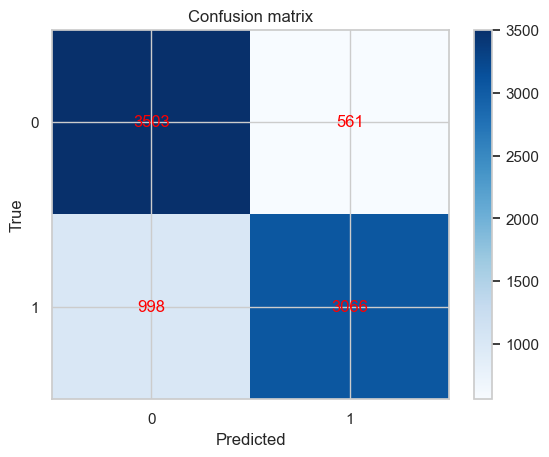

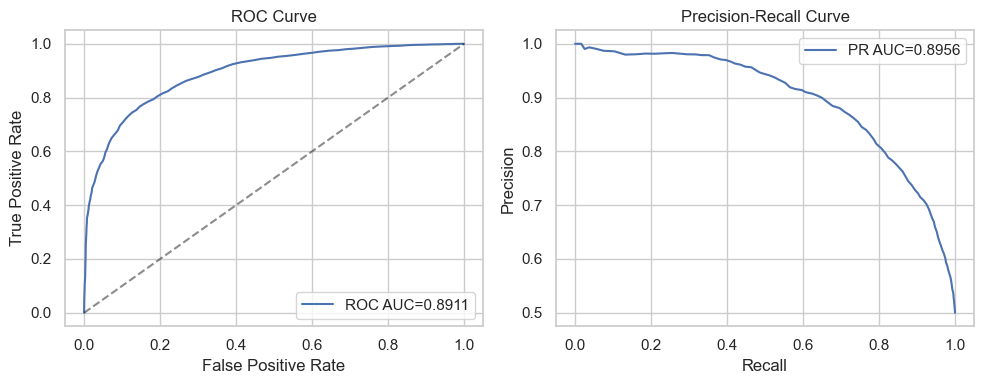

🏃 View run rumbling-fox-40 at: https://mlflow.openidealab.com/#/experiments/3/runs/1cb255254daf4fd1a0168c1bda5f03f6
🧪 View experiment at: https://mlflow.openidealab.com/#/experiments/3


{'recall': 0.7544291338582677,
 'precision': 0.8453267162944582,
 'f1': 0.7972955402418411,
 'accuracy': 0.8081938976377953,
 'roc_auc': np.float64(0.8910892743660488),
 'pr_auc': np.float64(0.8955790043509354)}

In [330]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)

model, metrics = train_antifraud_model(X_train, y_train, X_test=X_test, y_test=y_test, model=model, verbose=True)
metrics

In [331]:
# Получение важности признаков
importances = model.feature_importances_

# Создание списка признаков с их важностями
feature_names = X_train.columns  # или просто список имен признаков
important_features = list(zip(feature_names, importances))

# Сортировка по важности
important_features.sort(key=lambda x: x[1], reverse=True)

# Отображение наиболее важных признаков
for feature in important_features:
    print(f"Feature: {feature[0]}, Importance: {feature[1]}")

Feature: V_PCA_1, Importance: 0.04488416547675684
Feature: C13, Importance: 0.03185736087746033
Feature: V_PCA_5, Importance: 0.02837676243763519
Feature: Relative_TransactionDT, Importance: 0.02702729532573001
Feature: C14, Importance: 0.026617936199064374
Feature: log_TransactionAmt, Importance: 0.02518197029073022
Feature: card1, Importance: 0.024482384793258767
Feature: TransactionAmt, Importance: 0.02432757344333839
Feature: card1_count, Importance: 0.023990148170832004
Feature: Transaction_day, Importance: 0.02282214450553002
Feature: C1, Importance: 0.01974504114706794
Feature: V_PCA_0, Importance: 0.019044007795540812
Feature: addr1_count, Importance: 0.018338568999971928
Feature: C8, Importance: 0.017282518900330106
Feature: card2, Importance: 0.01720824096272429
Feature: C5, Importance: 0.017065446242861798
Feature: addr1, Importance: 0.017043169949082716
Feature: card2_count, Importance: 0.016726189633779177
Feature: C10, Importance: 0.01604465966916942
Feature: C2, Importan

##  Обучение модели  CatBoost

In [332]:

#from sklearn.model_selection import train_test_split

# X — ваши признаки (pandas.DataFrame или numpy.array)
# y — целевая переменная (Series или array)
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y,
#    test_size=0.2,     # 20% в тест, 80% в train
#    random_state=42,   # для воспроизводимости
#    stratify=y         # сохраняет пропорции классов (важно для антифрода!)
#)

In [333]:
cat_features = [
    'ProductCD',
    'card1', 
    'card2', 
    'card3', 
    'card4', 
    'card5', 
    'card6', 
    'addr1', 
    'addr2',
    'P_emaildomain',
    #'TransactionAmt_binned', 
]

In [334]:
!pip install boto3

JWT Token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJWT2xEWVppbU8tMGkzeDlMN2c5QWR5WFJGZEhDX1M0WldQN1MwVnJibFFjIn0.eyJleHAiOjE3NDg3NjU0MDAsImlhdCI6MTc0ODcyOTQwMCwianRpIjoiMDFlODI1YzItZTRlNy00NDkzLThmMDQtMGM1MjI5MjJiNmEzIiwiaXNzIjoiaHR0cHM6Ly9rZXljbG9hay5vcGVuaWRlYWxhYi5jb20vcmVhbG1zL29wZW5pZGVhbGFiLW1sIiwiYXVkIjpbImp1cHl0ZXIiLCJhaXJmbG93IiwiYWNjb3VudCJdLCJzdWIiOiIxOTIxZjBkMi0xMmIxLTRjMGQtODRlNi0xOGE2Yjg5ZTI0NzAiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJtbGZsb3ciLCJzZXNzaW9uX3N0YXRlIjoiMTE1OTkwZmEtODM1Yi00MTc3LTk1ZTYtMjllY2NiNTIzNWQ4IiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyJodHRwczovL21sZmxvdy5vcGVuaWRlYWxhYi5jb20iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLWp1cHl0ZXIiXX0sInJlc291cmNlX2FjY2VzcyI6eyJqdXB5dGVyIjp7InJvbGVzIjpbInVtYV9wcm90ZWN0aW9uIiwiYWRtaW4iLCJ1c2VyIl19LCJhaXJmbG93Ijp7InJvbGVzIjpbIkFkbWluIl19LCJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZ

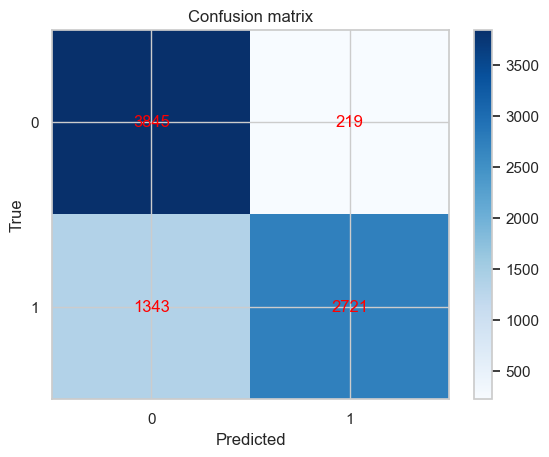

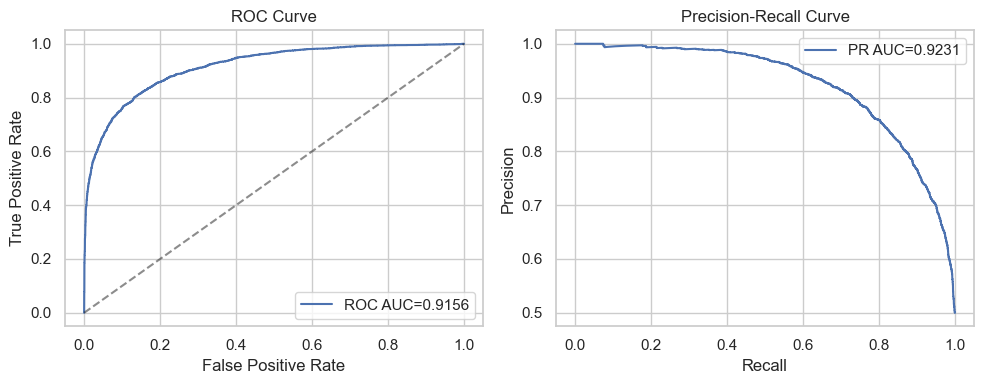

Object info sizes: 3 91
🏃 View run nervous-trout-521 at: https://mlflow.openidealab.com/#/experiments/3/runs/2cce629828554e59be4d2e04b02a0e7a
🧪 View experiment at: https://mlflow.openidealab.com/#/experiments/3


{'recall': 0.6695374015748031,
 'precision': 0.9255102040816326,
 'f1': 0.7769845802398629,
 'accuracy': 0.8078248031496063,
 'roc_auc': np.float64(0.9155902823524397),
 'pr_auc': np.float64(0.9231303988501457)}

In [335]:
from catboost import CatBoostClassifier

my_model = CatBoostClassifier(
            loss_function='Logloss',
            eval_metric='AUC',
            #eval_metric='Logloss', 
            iterations=1000,
            early_stopping_rounds=50,
            cat_features=cat_features,
            verbose=False,
            #task_type="GPU",
)

#best_params = {'learning_rate': 0.03574712922600244, 'depth': 10, 'l2_leaf_reg': 5.395030966670228, 'bagging_temperature': 0.5986584841970366, 'random_strength': 2.4041677639819286, 'border_count': 66, 'scale_pos_weight': 6.750277604651747}
#my_model = CatBoostClassifier(verbose=False, **best_params)
#cv = TimeSeriesSplit(n_splits=5)

model, metrics = train_antifraud_model(X_train, y_train, X_test=X_test, y_test=y_test, model=my_model, verbose=True)
metrics

In [336]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0, 1),
        'random_strength': trial.suggest_float("random_strength", 1, 10),
        'border_count': trial.suggest_int("border_count", 32, 255),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 100.0),
        'iterations': 500,
        'early_stopping_rounds': 10,
        #'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'eval_metric': 'Logloss',  
        'cat_features': cat_features,
        'verbose': True,
        'random_state': 42,
        #'task_type': "GPU", 
    }

    model = CatBoostClassifier(**params)
    cv = TimeSeriesSplit(n_splits=3)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=1)
    return scores.mean()

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True, gc_after_trial=True, n_jobs=-1)

print("Лучшие параметры:", study.best_params)
print("Лучший результат AUC:", study.best_value)

[I 2025-06-01 01:10:26,524] A new study created in memory with name: no-name-4a64d801-9b1a-477d-93ce-2be44f0db8e0
  0%|          | 0/20 [00:00<?, ?it/s]

Object info sizes: 8301 91
0:	learn: 0.6406462	total: 94.3ms	remaining: 47s
0:	learn: 0.6069003	total: 146ms	remaining: 1m 12s
0:	learn: 0.6577753	total: 101ms	remaining: 50.2s
1:	learn: 0.5929224	total: 145ms	remaining: 36s
0:	learn: 0.6477913	total: 91.4ms	remaining: 45.6s
0:	learn: 0.6438014	total: 80.5ms	remaining: 40.2s
1:	learn: 0.6249103	total: 129ms	remaining: 32.2s
1:	learn: 0.5989585	total: 100ms	remaining: 25s
1:	learn: 0.6060065	total: 118ms	remaining: 29.4s
2:	learn: 0.5492858	total: 177ms	remaining: 29.3s
0:	learn: 0.6095050	total: 90.5ms	remaining: 45.1s
0:	learn: 0.5815093	total: 144ms	remaining: 1m 11s
0:	learn: 0.6849284	total: 79ms	remaining: 39.4s
2:	learn: 0.5953495	total: 158ms	remaining: 26.2s
2:	learn: 0.5623170	total: 125ms	remaining: 20.6s
1:	learn: 0.5404899	total: 225ms	remaining: 56s
2:	learn: 0.5670223	total: 152ms	remaining: 25.2s
3:	learn: 0.5306324	total: 138ms	remaining: 17.1s
3:	learn: 0.5098179	total: 208ms	remaining: 25.8s
0:	learn: 0.6653391	total:

  0%|          | 0/20 [00:58<?, ?it/s]

493:	learn: 0.1349616	total: 27.8s	remaining: 337ms
478:	learn: 0.0495277	total: 58.2s	remaining: 2.55s
427:	learn: 0.0694788	total: 26s	remaining: 4.37s
card1_count, bin=129 score 2.17713385

{ProductCD, card6, V_PCA_2 b12, V_PCA_25 b92} pr1 tb0 type0, border=9 score 6.643238561
V_PCA_17, bin=42 score 13.03547662
V_PCA_0, bin=56 score 3.41137702
{card1} pr0 tb0 type1, border=5 score 19.3860917
C6, bin=34 score 24.98586594
V_PCA_35, bin=193 score 4.400262339
P_emaildomain_count, bin=26 score 4.480549857
367:	learn: 0.0643218	total: 22.9s	remaining: 8.23s
463:	learn: 0.0737448	total: 35.6s	remaining: 2.76s


V_PCA_10, bin=185 score 5.145407765
C9, bin=123 score 1.522548233
V_PCA_1, bin=26 score 6.143160404
{card6, addr1} pr2 tb0 type0, border=0 score 2.317062453
[I 2025-06-01 01:11:25,146] Trial 8 finished with value: 0.8467333955262046 and parameters: {'learning_rate': 0.010085771993763218, 'depth': 4, 'l2_leaf_reg': 1.540011732878479, 'bagging_temperature': 0.34882864587507256, 'rando

Best trial: 8. Best value: 0.846733:   5%|▌         | 1/20 [00:58<18:37, 58.83s/it]

479:	learn: 0.0493738	total: 58.2s	remaining: 2.43s
494:	learn: 0.1349182	total: 27.8s	remaining: 281ms
464:	learn: 0.0737448	total: 35.7s	remaining: 2.68s
168:	learn: 0.2864863	total: 13.3s	remaining: 26.1s
368:	learn: 0.0642993	total: 23s	remaining: 8.16s
428:	learn: 0.0694591	total: 26s	remaining: 4.31s
193:	learn: 0.0551076	total: 14.3s	remaining: 22.5s
295:	learn: 0.1323836	total: 28.6s	remaining: 19.7s
{card3} pr2 tb0 type0, border=2 score 2.326125468
{card4, C6 b3, C3 b3} pr1 tb0 type0, border=0 score 15.33729814
TransactionAmt, bin=141 score 3.824251261
  tensor 3 is redundant, remove it and stop
{P_emaildomain} pr0 tb0 type0, border=3 score 6.792259109
495:	learn: 0.1348614	total: 27.9s	remaining: 225ms
{card5} pr0 tb0 type1, border=12 score 23.58863685
369:	learn: 0.0642883	total: 23s	remaining: 8.09s

V_PCA_30, bin=174 score 3.637152744

{card4, P_emaildomain} pr0 tb0 type1, border=3 score 5.025348741
{card3, card4} pr0 tb0 type0, border=12 score 2.624311428
{addr2, P_emaild

Best trial: 8. Best value: 0.846733:  10%|█         | 2/20 [00:59<07:19, 24.41s/it]

496:	learn: 0.1348236	total: 28.1s	remaining: 170ms
371:	learn: 0.0642546	total: 23.3s	remaining: 8.02s
0:	learn: 0.5662307	total: 229ms	remaining: 1m 54s
466:	learn: 0.0736990	total: 36s	remaining: 2.54s
195:	learn: 0.0550578	total: 14.6s	remaining: 22.7s
430:	learn: 0.0694429	total: 26.4s	remaining: 4.22s
497:	learn: 0.1347862	total: 28.2s	remaining: 113ms
170:	learn: 0.2861189	total: 13.7s	remaining: 26.4s
196:	learn: 0.0550380	total: 14.7s	remaining: 22.5s
467:	learn: 0.0736925	total: 36s	remaining: 2.46s
431:	learn: 0.0694280	total: 26.4s	remaining: 4.16s
1:	learn: 0.4766822	total: 291ms	remaining: 1m 12s
297:	learn: 0.1320642	total: 29s	remaining: 19.7s
481:	learn: 0.0493560	total: 58.6s	remaining: 2.19s
372:	learn: 0.0642472	total: 23.4s	remaining: 7.97s
2:	learn: 0.4105394	total: 353ms	remaining: 58.5s
171:	learn: 0.2859257	total: 13.8s	remaining: 26.3s
498:	learn: 0.1347535	total: 28.3s	remaining: 56.7ms
432:	learn: 0.0694147	total: 26.5s	remaining: 4.1s
3:	learn: 0.3609302	to

Best trial: 8. Best value: 0.846733:  10%|█         | 2/20 [00:59<07:19, 24.41s/it]

11:	learn: 0.1957265	total: 631ms	remaining: 25.6s
376:	learn: 0.0641473	total: 23.7s	remaining: 7.74s
3:	learn: 0.6217232	total: 216ms	remaining: 26.8s
484:	learn: 0.0493387	total: 59s	remaining: 1.82s
438:	learn: 0.0692550	total: 26.8s	remaining: 3.72s
472:	learn: 0.0734552	total: 36.4s	remaining: 2.08s
4:	learn: 0.6066466	total: 237ms	remaining: 23.4s
201:	learn: 0.0549620	total: 15.1s	remaining: 22.2s
377:	learn: 0.0641473	total: 23.8s	remaining: 7.67s
175:	learn: 0.2848081	total: 14.1s	remaining: 26s
12:	learn: 0.1880379	total: 690ms	remaining: 25.8s
13:	learn: 0.1841639	total: 702ms	remaining: 24.4s
301:	learn: 0.1312722	total: 29.4s	remaining: 19.3s
439:	learn: 0.0692550	total: 26.8s	remaining: 3.66s
5:	learn: 0.5905556	total: 298ms	remaining: 24.5s
V_PCA_34, bin=135 score 19.80761357
{card4, card5} pr2 tb0 type0, border=3 score 4.826255427
{card6, V_PCA_1 b27, card1_count b13} pr1 tb0 type0, border=8 score 24.44744417
176:	learn: 0.2847133	total: 14.2s	remaining: 25.9s
addr2_co

Best trial: 6. Best value: 0.909562:  15%|█▌        | 3/20 [00:59<03:51, 13.62s/it]

177:	learn: 0.2843321	total: 14.3s	remaining: 25.8s
302:	learn: 0.1311938	total: 29.5s	remaining: 19.2s
16:	learn: 0.1704496	total: 851ms	remaining: 24.2s
8:	learn: 0.5491437	total: 393ms	remaining: 21.4s
17:	learn: 0.1691559	total: 861ms	remaining: 23.1s
178:	learn: 0.2840729	total: 14.3s	remaining: 25.7s
18:	learn: 0.1681336	total: 866ms	remaining: 21.9s
441:	learn: 0.0692272	total: 27s	remaining: 3.54s
9:	learn: 0.5367995	total: 418ms	remaining: 20.5s
380:	learn: 0.0640975	total: 24s	remaining: 7.49s
442:	learn: 0.0692272	total: 27s	remaining: 3.47s
475:	learn: 0.0733343	total: 36.7s	remaining: 1.85s
204:	learn: 0.0549020	total: 15.3s	remaining: 22s
19:	learn: 0.1656667	total: 899ms	remaining: 21.6s
205:	learn: 0.0549020	total: 15.3s	remaining: 21.9s
381:	learn: 0.0640897	total: 24s	remaining: 7.42s
303:	learn: 0.1311229	total: 29.6s	remaining: 19.1s
10:	learn: 0.5240340	total: 462ms	remaining: 20.5s
11:	learn: 0.5136749	total: 467ms	remaining: 19s
20:	learn: 0.1630257	total: 941ms	

Best trial: 6. Best value: 0.909562:  15%|█▌        | 3/20 [01:04<03:51, 13.62s/it]

228:	learn: 0.2734070	total: 18.2s	remaining: 21.6s
107:	learn: 0.1216136	total: 4.78s	remaining: 17.4s
342:	learn: 0.1261383	total: 33.5s	remaining: 15.3s
12:	learn: 0.1507800	total: 1.2s	remaining: 45s
97:	learn: 0.1005825	total: 3.88s	remaining: 15.9s
443:	learn: 0.0629448	total: 27.9s	remaining: 3.52s
92:	learn: 0.2514357	total: 4.36s	remaining: 19.1s
259:	learn: 0.0539997	total: 19.2s	remaining: 17.7s
260:	learn: 0.0539997	total: 19.3s	remaining: 17.6s
229:	learn: 0.2732549	total: 18.3s	remaining: 21.5s
108:	learn: 0.1212142	total: 4.85s	remaining: 17.4s
93:	learn: 0.2508733	total: 4.4s	remaining: 19s
444:	learn: 0.0629047	total: 28s	remaining: 3.46s
13:	learn: 0.1436055	total: 1.26s	remaining: 43.8s
98:	learn: 0.1004726	total: 3.94s	remaining: 16s
100:	learn: 0.1003384	total: 3.98s	remaining: 15.7s
11:	learn: 0.1210008	total: 1.76s	remaining: 1m 11s
C6, bin=2 score 4.634336789
V_PCA_16, bin=78 score 10.91120694
C13, bin=172 score 1.879937013
{card6} pr2 tb0 type0, border=6 score 

Best trial: 6. Best value: 0.909562:  20%|██        | 4/20 [01:04<02:39,  9.96s/it]

111:	learn: 0.1201352	total: 4.98s	remaining: 17.2s
102:	learn: 0.1002037	total: 4.08s	remaining: 15.7s
447:	learn: 0.0628820	total: 28.1s	remaining: 3.26s
15:	learn: 0.1318510	total: 1.4s	remaining: 42.4s
232:	learn: 0.2724518	total: 18.5s	remaining: 21.2s
97:	learn: 0.2474860	total: 4.59s	remaining: 18.8s
263:	learn: 0.0539354	total: 19.4s	remaining: 17.4s
16:	learn: 0.1277044	total: 1.43s	remaining: 40.5s
112:	learn: 0.1199259	total: 5.02s	remaining: 17.2s
98:	learn: 0.2472957	total: 4.6s	remaining: 18.6s
99:	learn: 0.2471244	total: 4.62s	remaining: 18.5s
103:	learn: 0.1000287	total: 4.13s	remaining: 15.7s
113:	learn: 0.1197390	total: 5.05s	remaining: 17.1s
448:	learn: 0.0628731	total: 28.2s	remaining: 3.2s
233:	learn: 0.2720789	total: 18.6s	remaining: 21.1s
345:	learn: 0.1259258	total: 33.8s	remaining: 15s
114:	learn: 0.1195828	total: 5.1s	remaining: 17.1s
100:	learn: 0.2465335	total: 4.68s	remaining: 18.5s
104:	learn: 0.0999345	total: 4.19s	remaining: 15.8s
264:	learn: 0.0539246	t

Best trial: 6. Best value: 0.909562:  20%|██        | 4/20 [01:08<02:39,  9.96s/it]

312:	learn: 0.0532285	total: 23s	remaining: 13.7s
278:	learn: 0.2609800	total: 22.1s	remaining: 17.5s
188:	learn: 0.1075884	total: 8.57s	remaining: 14.1s
380:	learn: 0.1223255	total: 37.3s	remaining: 11.7s
38:	learn: 0.2114630	total: 3.57s	remaining: 42.2s
170:	learn: 0.2254683	total: 8.17s	remaining: 15.7s
39:	learn: 0.2064101	total: 3.58s	remaining: 41.2s
40:	learn: 0.2013293	total: 3.59s	remaining: 40.2s
187:	learn: 0.0944164	total: 7.69s	remaining: 12.8s
189:	learn: 0.1075883	total: 8.62s	remaining: 14.1s
313:	learn: 0.0530697	total: 23.1s	remaining: 13.7s
41:	learn: 0.1964949	total: 3.63s	remaining: 39.6s
279:	learn: 0.2607008	total: 22.1s	remaining: 17.4s
56:	learn: 0.0927743	total: 5.05s	remaining: 39.3s
C3, bin=0 score 3.708172053
card6_count, bin=1 score 321.827123
Transaction_day, bin=70 score 24.75353395
V_PCA_9, bin=85 score 373.6776568
{card6, P_emaildomain} pr2 tb0 type0, border=1 score 4.040603695
addr1_count, bin=30 score 8.854133117
188:	learn: 0.0944164	total: 7.75s	r

Best trial: 6. Best value: 0.909562:  25%|██▌       | 5/20 [01:08<01:56,  7.79s/it]

381:	learn: 0.1221402	total: 37.4s	remaining: 11.6s
280:	learn: 0.2605375	total: 22.2s	remaining: 17.3s
191:	learn: 0.1070606	total: 8.74s	remaining: 14s
315:	learn: 0.0530593	total: 23.2s	remaining: 13.5s
172:	learn: 0.2251205	total: 8.32s	remaining: 15.7s
190:	learn: 0.0944132	total: 7.83s	remaining: 12.7s
43:	learn: 0.0764095	total: 5.71s	remaining: 59.2s
44:	learn: 0.1824787	total: 3.77s	remaining: 38.1s
281:	learn: 0.2602704	total: 22.3s	remaining: 17.2s
192:	learn: 0.1070606	total: 8.77s	remaining: 14s
173:	learn: 0.2248481	total: 8.36s	remaining: 15.7s
191:	learn: 0.0944101	total: 7.87s	remaining: 12.6s
316:	learn: 0.0530593	total: 23.2s	remaining: 13.4s
382:	learn: 0.1221090	total: 37.5s	remaining: 11.5s
174:	learn: 0.2247952	total: 8.38s	remaining: 15.6s
175:	learn: 0.2247757	total: 8.39s	remaining: 15.4s
58:	learn: 0.0924784	total: 5.25s	remaining: 39.3s
192:	learn: 0.0944100	total: 7.91s	remaining: 12.6s
317:	learn: 0.0530592	total: 23.3s	remaining: 13.3s
193:	learn: 0.10698

Best trial: 6. Best value: 0.909562:  25%|██▌       | 5/20 [01:21<01:56,  7.79s/it]

480:	learn: 0.0855865	total: 22.1s	remaining: 873ms
129:	learn: 0.0653921	total: 19.1s	remaining: 54.4s
481:	learn: 0.0855808	total: 22.1s	remaining: 826ms
468:	learn: 0.1975267	total: 21.7s	remaining: 1.44s
185:	learn: 0.0531240	total: 17.2s	remaining: 29s
C7, bin=19 score 22.35208785
440:	learn: 0.2363647	total: 35.6s	remaining: 4.77s
V_PCA_35, bin=53 score 49.50168768
V_PCA_23, bin=1 score 0.855285786
{card3} pr0 tb0 type0, border=12 score 0.6324846997
186:	learn: 0.1114827	total: 13.4s	remaining: 22.4s
C1, bin=34 score 12.82715132
card4_count, bin=3 score 13.58863849
{ProductCD} pr0 tb0 type1, border=4 score 39.03730814
V_PCA_9, bin=101 score 3.026453222
Relative_TransactionDT, bin=106 score 2.161451582
{addr1, addr2} pr0 tb0 type1, border=6 score 17.71349331
V_PCA_30, bin=25 score 32.82290791
ProductCD_count, bin=2 score 15.96983261
C13, bin=69 score 10.44444388
482:	learn: 0.0855762	total: 22.2s	remaining: 781ms
Relative_TransactionDT, bin=172 score 11.79963405
addr2_count, bin=1

Best trial: 6. Best value: 0.909562:  30%|███       | 6/20 [01:22<02:17,  9.83s/it]

186:	learn: 0.0530341	total: 17.5s	remaining: 29.3s
471:	learn: 0.1974557	total: 22s	remaining: 1.31s
215:	learn: 0.0780752	total: 18.9s	remaining: 24.9s
130:	learn: 0.0653471	total: 19.5s	remaining: 54.8s
442:	learn: 0.2362377	total: 36s	remaining: 4.63s
484:	learn: 0.0854690	total: 22.5s	remaining: 696ms
187:	learn: 0.0529694	total: 17.6s	remaining: 29.2s
472:	learn: 0.1974507	total: 22.1s	remaining: 1.26s
188:	learn: 0.0529108	total: 17.6s	remaining: 28.9s
0:	learn: 0.6468948	total: 38ms	remaining: 19s
0:	learn: 0.5429963	total: 296ms	remaining: 2m 27s
188:	learn: 0.1111889	total: 13.8s	remaining: 22.7s
1:	learn: 0.6069528	total: 60.6ms	remaining: 15.1s
2:	learn: 0.5675866	total: 74.5ms	remaining: 12.3s
485:	learn: 0.0854671	total: 22.6s	remaining: 650ms
473:	learn: 0.1973391	total: 22.2s	remaining: 1.22s
443:	learn: 0.2361842	total: 36.1s	remaining: 4.55s
216:	learn: 0.0777954	total: 19.1s	remaining: 24.9s
3:	learn: 0.5305489	total: 116ms	remaining: 14.4s
486:	learn: 0.0854670	tota

Best trial: 6. Best value: 0.909562:  30%|███       | 6/20 [01:27<02:17,  9.83s/it]

275:	learn: 0.0750380	total: 4.93s	remaining: 4s
255:	learn: 0.0498372	total: 22.6s	remaining: 21.5s
43:	learn: 0.3167213	total: 3s	remaining: 31.1s
78:	learn: 0.1028198	total: 5.29s	remaining: 28.2s
276:	learn: 0.0750380	total: 4.95s	remaining: 3.99s
266:	learn: 0.0715840	total: 24s	remaining: 21s
45:	learn: 0.2134891	total: 4.91s	remaining: 48.5s
277:	learn: 0.0750230	total: 4.97s	remaining: 3.97s
278:	learn: 0.0749770	total: 4.98s	remaining: 3.94s
279:	learn: 0.0749367	total: 4.99s	remaining: 3.92s
53:	learn: 0.1357571	total: 4s	remaining: 33s
44:	learn: 0.3135984	total: 3.07s	remaining: 31s
280:	learn: 0.0749258	total: 5.01s	remaining: 3.9s
79:	learn: 0.1027021	total: 5.36s	remaining: 28.1s
259:	learn: 0.1058718	total: 18.8s	remaining: 17.4s
281:	learn: 0.0749198	total: 5.03s	remaining: 3.88s
260:	learn: 0.1058664	total: 18.8s	remaining: 17.3s
283:	learn: 0.0748714	total: 5.05s	remaining: 3.84s
256:	learn: 0.0498108	total: 22.7s	remaining: 21.4s
54:	learn: 0.1355038	total: 4.06s	re

Best trial: 5. Best value: 0.933509:  35%|███▌      | 7/20 [01:27<01:49,  8.41s/it]

268:	learn: 0.0714872	total: 24.2s	remaining: 20.8s
47:	learn: 0.2118226	total: 5.14s	remaining: 48.4s
262:	learn: 0.1056820	total: 19s	remaining: 17.1s
287:	learn: 0.0747495	total: 5.11s	remaining: 3.76s
263:	learn: 0.1056462	total: 19s	remaining: 17s
288:	learn: 0.0747448	total: 5.13s	remaining: 3.74s
289:	learn: 0.0747318	total: 5.16s	remaining: 3.73s
56:	learn: 0.1351553	total: 4.21s	remaining: 32.7s
290:	learn: 0.0747318	total: 5.16s	remaining: 3.71s
82:	learn: 0.1025744	total: 5.52s	remaining: 27.8s
48:	learn: 0.3041859	total: 3.31s	remaining: 30.5s
291:	learn: 0.0746651	total: 5.17s	remaining: 3.69s
258:	learn: 0.0497631	total: 22.9s	remaining: 21.3s
0:	learn: 0.4037482	total: 21.5ms	remaining: 10.7s
292:	learn: 0.0746446	total: 5.19s	remaining: 3.67s
259:	learn: 0.0497434	total: 22.9s	remaining: 21.1s
269:	learn: 0.0714252	total: 24.4s	remaining: 20.7s
260:	learn: 0.0497313	total: 22.9s	remaining: 21s
48:	learn: 0.2109681	total: 5.26s	remaining: 48.4s
293:	learn: 0.0746250	tota

Best trial: 5. Best value: 0.933509:  35%|███▌      | 7/20 [01:49<01:49,  8.41s/it]

241:	learn: 0.1383201	total: 27.2s	remaining: 29s
469:	learn: 0.0713018	total: 17.3s	remaining: 1.1s
350:	learn: 0.0913926	total: 26.2s	remaining: 11.1s
235:	learn: 0.0646525	total: 11.3s	remaining: 12.6s
309:	learn: 0.2040007	total: 25.4s	remaining: 15.6s
{card3} pr1 tb0 type0, border=13 score 1157.742219
470:	learn: 0.0712824	total: 17.3s	remaining: 1.06s
C3, bin=0 score 2.267442754

{card4, P_emaildomain} pr0 tb0 type1, border=0 score 5.219788933
{card1} pr0 tb0 type1, border=3 score 15.14176414
{card2, C9 b1, card2_count b28} pr2 tb0 type0, border=2 score 4.424077472
C3, bin=0 score 5.701975232
C9, bin=123 score 2.984722009
{card3} pr2 tb0 type0, border=1 score 1089.914277
  tensor 4 is redundant, remove it and stop
{ProductCD, addr2} pr2 tb0 type0, border=6 score 146.8827534
V_PCA_22, bin=26 score 1.899002538
C8, bin=30 score 10.76774313
{card4} pr2 tb0 type0, border=14 score 3.269314361
{card4, addr1, P_emaildomain} pr2 tb0 type0, border=1 score 5.948493038
{card5, C9 b123, C3 b0

Best trial: 5. Best value: 0.933509:  40%|████      | 8/20 [01:49<02:34, 12.89s/it]

472:	learn: 0.0712472	total: 17.4s	remaining: 993ms
28:	learn: 0.2640425	total: 2.99s	remaining: 48.6s
237:	learn: 0.0646524	total: 11.4s	remaining: 12.5s
243:	learn: 0.1377096	total: 27.4s	remaining: 28.8s
396:	learn: 0.0733849	total: 27.7s	remaining: 7.19s
286:	learn: 0.0572411	total: 47.1s	remaining: 35s
352:	learn: 0.0913045	total: 26.3s	remaining: 11s
311:	learn: 0.2039434	total: 25.5s	remaining: 15.3s
7:	learn: 0.5252521	total: 1.06s	remaining: 1m 5s
312:	learn: 0.2039433	total: 25.5s	remaining: 15.2s
473:	learn: 0.0712385	total: 17.4s	remaining: 956ms
238:	learn: 0.0646523	total: 11.4s	remaining: 12.5s
474:	learn: 0.0712231	total: 17.5s	remaining: 919ms
239:	learn: 0.0646522	total: 11.5s	remaining: 12.4s
397:	learn: 0.0733085	total: 27.8s	remaining: 7.12s
353:	learn: 0.0911720	total: 26.4s	remaining: 10.9s
475:	learn: 0.0712231	total: 17.5s	remaining: 882ms
313:	learn: 0.2038720	total: 25.6s	remaining: 15.1s
29:	learn: 0.2572929	total: 3.11s	remaining: 48.8s
240:	learn: 0.064652

Best trial: 5. Best value: 0.933509:  40%|████      | 8/20 [02:16<02:34, 12.89s/it]

187:	learn: 0.1429073	total: 10.9s	remaining: 18.1s
457:	learn: 0.1123081	total: 53.9s	remaining: 4.94s
155:	learn: 0.1061537	total: 15.1s	remaining: 33.3s
185:	learn: 0.0834886	total: 17.1s	remaining: 28.9s
212:	learn: 0.0621236	total: 13s	remaining: 17.5s
233:	learn: 0.0500873	total: 27.5s	remaining: 31.2s
421:	learn: 0.0534119	total: 1m 13s	remaining: 13.6s
252:	learn: 0.1049154	total: 29.4s	remaining: 28.7s
78:	learn: 0.2586313	total: 8.53s	remaining: 45.5s

V_PCA_6, bin=8 score 4.741989264
D4, bin=87 score 36.95595789
234:	learn: 0.0500633	total: 27.5s	remaining: 31s

188:	learn: 0.1427782	total: 11s	remaining: 18.1s
V_PCA_14, bin=67 score 34.80980791
Transaction_day, bin=46 score 3.489746966
V_PCA_32, bin=0 score 4.593696004

{card1} pr1 tb0 type0, border=2 score 7.316829347
C5, bin=119 score 6.477805522
C13, bin=61 score 5.055415441
V_PCA_25, bin=134 score 6.488057047
card1_count, bin=81 score 30.40682364
253:	learn: 0.1049074	total: 29.5s	remaining: 28.5s
156:	learn: 0.1060268	

Best trial: 5. Best value: 0.933509:  45%|████▌     | 9/20 [02:16<03:09, 17.26s/it]

189:	learn: 0.1426963	total: 11.1s	remaining: 18.1s
79:	learn: 0.2576231	total: 8.64s	remaining: 45.4s
422:	learn: 0.0533838	total: 1m 13s	remaining: 13.4s
190:	learn: 0.1426022	total: 11.1s	remaining: 18s
214:	learn: 0.0621235	total: 13.2s	remaining: 17.5s
236:	learn: 0.0499827	total: 27.7s	remaining: 30.7s
188:	learn: 0.0832294	total: 17.4s	remaining: 28.6s
80:	learn: 0.2565711	total: 8.74s	remaining: 45.2s
459:	learn: 0.1121363	total: 54.1s	remaining: 4.71s
215:	learn: 0.0621235	total: 13.2s	remaining: 17.4s
158:	learn: 0.1057363	total: 15.4s	remaining: 33s
191:	learn: 0.1425315	total: 11.2s	remaining: 17.9s
255:	learn: 0.1047967	total: 29.7s	remaining: 28.3s
216:	learn: 0.0621235	total: 13.3s	remaining: 17.3s
192:	learn: 0.1423879	total: 11.2s	remaining: 17.9s
189:	learn: 0.0832001	total: 17.5s	remaining: 28.5s
423:	learn: 0.0533811	total: 1m 13s	remaining: 13.2s
81:	learn: 0.2555541	total: 8.85s	remaining: 45.1s
190:	learn: 0.0832001	total: 17.5s	remaining: 28.3s
0:	learn: 0.44839

Best trial: 5. Best value: 0.933509:  45%|████▌     | 9/20 [02:23<03:09, 17.26s/it]

D1, bin=158 score 4.234351676
222:	learn: 0.0984028	total: 21.9s	remaining: 27.2s

{ProductCD, card1, card6} pr0 tb0 type1, border=9 score 17.39562641
{addr2} pr1 tb0 type0, border=5 score 0.8407289244
{card5} pr0 tb0 type1, border=12 score 32.00020382
264:	learn: 0.0789878	total: 23.9s	remaining: 21.2s
[I 2025-06-01 01:12:49,963] Trial 0 finished with value: 0.9342384043872013 and parameters: {'learning_rate': 0.07677425681853858, 'depth': 8, 'l2_leaf_reg': 5.263175198165101, 'bagging_temperature': 0.6164628997559317, 'random_strength': 5.250705540959175, 'border_count': 202, 'scale_pos_weight': 11.422260213876235}. Best is trial 0 with value: 0.9342384043872013.


Best trial: 0. Best value: 0.934238:  50%|█████     | 10/20 [02:23<02:20, 14.03s/it]

189:	learn: 0.0559789	total: 6.44s	remaining: 10.5s
301:	learn: 0.1313622	total: 17.7s	remaining: 11.6s
265:	learn: 0.0789878	total: 23.9s	remaining: 21s
307:	learn: 0.1015529	total: 36.2s	remaining: 22.6s
223:	learn: 0.0983628	total: 22s	remaining: 27s
459:	learn: 0.0526009	total: 1m 20s	remaining: 6.99s
150:	learn: 0.2236147	total: 15.3s	remaining: 35.4s
284:	learn: 0.0487195	total: 34.3s	remaining: 25.9s
338:	learn: 0.0616446	total: 19.8s	remaining: 9.38s
285:	learn: 0.0487156	total: 34.3s	remaining: 25.7s
190:	learn: 0.0559718	total: 6.51s	remaining: 10.5s
339:	learn: 0.0616446	total: 19.8s	remaining: 9.33s
302:	learn: 0.1312991	total: 17.8s	remaining: 11.6s
266:	learn: 0.0789559	total: 24s	remaining: 21s
151:	learn: 0.2232885	total: 15.4s	remaining: 35.3s
191:	learn: 0.0559718	total: 6.54s	remaining: 10.5s
224:	learn: 0.0982443	total: 22.1s	remaining: 27s
308:	learn: 0.1014590	total: 36.3s	remaining: 22.5s
340:	learn: 0.0616444	total: 19.9s	remaining: 9.27s
303:	learn: 0.1312223	t

Best trial: 0. Best value: 0.934238:  50%|█████     | 10/20 [02:34<02:20, 14.03s/it]

11:	learn: 0.1223296	total: 2.25s	remaining: 1m 31s
392:	learn: 0.0740950	total: 34.5s	remaining: 9.4s
468:	learn: 0.0530517	total: 17.1s	remaining: 1.13s
252:	learn: 0.2066548	total: 26s	remaining: 25.4s

377:	learn: 0.0473671	total: 45s	remaining: 14.5s

479:	learn: 0.1203686	total: 28.4s	remaining: 1.18s

V_PCA_6, bin=113 score 16.64848954
469:	learn: 0.0530517	total: 17.1s	remaining: 1.09s
V_PCA_6, bin=65 score 28.66027449

card5_count, bin=0 score 0.9974858199
{addr2, V_PCA_25 b170, V_PCA_9 b62, V_PCA_16 b137} pr2 tb0 type0, border=8 score 83.38060659
V_PCA_16, bin=13 score 4.227732091
C10, bin=92 score 4.982020473
C3, bin=0 score 2.830172593
{card3, addr2} pr1 tb0 type0, border=1 score 3.058630233
{card3, V_PCA_6 b113} pr0 tb0 type0, border=11 score 16.06903669
C9, bin=107 score 3.231678892
{card6, V_PCA_6 b65} pr0 tb0 type0, border=3 score 20.6610424
{card5} pr1 tb0 type0, border=0 score 1.345681213
108:	learn: 0.0447853	total: 10.5s	remaining: 37.8s

{ProductCD, card2, card3} p

Best trial: 0. Best value: 0.934238:  55%|█████▌    | 11/20 [02:34<01:57, 13.10s/it]

403:	learn: 0.0975512	total: 47s	remaining: 11.2s
254:	learn: 0.2064809	total: 26.1s	remaining: 25.1s
481:	learn: 0.1203196	total: 28.5s	remaining: 1.06s
394:	learn: 0.0740867	total: 34.7s	remaining: 9.22s
109:	learn: 0.0447831	total: 10.7s	remaining: 37.8s
13:	learn: 0.1097751	total: 2.42s	remaining: 1m 24s
378:	learn: 0.0473479	total: 45.1s	remaining: 14.4s
326:	learn: 0.0901942	total: 32.8s	remaining: 17.3s
379:	learn: 0.0473461	total: 45.2s	remaining: 14.3s
473:	learn: 0.0530516	total: 17.2s	remaining: 945ms
482:	learn: 0.1202657	total: 28.6s	remaining: 1s
474:	learn: 0.0530516	total: 17.3s	remaining: 909ms
327:	learn: 0.0901181	total: 32.9s	remaining: 17.2s
395:	learn: 0.0740758	total: 34.8s	remaining: 9.13s
255:	learn: 0.2062007	total: 26.2s	remaining: 25s
483:	learn: 0.1202657	total: 28.6s	remaining: 945ms
475:	learn: 0.0530515	total: 17.3s	remaining: 873ms
404:	learn: 0.0975232	total: 47.1s	remaining: 11.1s
110:	learn: 0.0447795	total: 10.8s	remaining: 37.9s
476:	learn: 0.05305

Best trial: 0. Best value: 0.934238:  55%|█████▌    | 11/20 [02:43<01:57, 13.10s/it]

144:	learn: 0.0542438	total: 7.99s	remaining: 19.6s
{card3, card6} pr1 tb0 type0, border=1 score 1.470587492

V_PCA_17, bin=4 score 21.63627609
C9, bin=123 score 2.364178564
C10, bin=27 score 17.88417243
498:	learn: 0.0943510	total: 56.2s	remaining: 113ms

C3, bin=0 score 2.879838739
{card3, card4, card6} pr1 tb0 type0, border=3 score 1.623051109
C2, bin=65 score 24.53819697
{P_emaildomain} pr1 tb0 type0, border=7 score 9.573354019
C5, bin=185 score 3.188372429
{P_emaildomain, C3 b0, C11 b115, V_PCA_28 b4, card2_count b94, V_PCA_29 b117, V_PCA_17 b4} pr0 tb0 type0, border=0 score 20.80381453
{card3, card4, card6, addr2} pr1 tb0 type0, border=1 score 2.252837152
V_PCA_26, bin=24 score 10.21052702
card5_count, bin=0 score 3.423068877
{card2, P_emaildomain} pr0 tb0 type0, border=3 score 12.21632325
99:	learn: 0.1533217	total: 7.38s	remaining: 29.5s
{card3, addr2} pr1 tb0 type0, border=2 score 2.743177318

{card5} pr0 tb0 type0, border=12 score 6.140502946
V_PCA_2, bin=36 score 22.53850107

Best trial: 0. Best value: 0.934238:  60%|██████    | 12/20 [02:44<01:36, 12.01s/it]

67:	learn: 0.0707889	total: 11.7s	remaining: 1m 14s
355:	learn: 0.1979777	total: 35.4s	remaining: 14.3s
499:	learn: 0.0943390	total: 56.2s	remaining: 0us
428:	learn: 0.0856107	total: 42s	remaining: 6.96s
145:	learn: 0.0542437	total: 8.06s	remaining: 19.5s
464:	learn: 0.0463961	total: 54.5s	remaining: 4.1s
100:	learn: 0.1531661	total: 7.47s	remaining: 29.5s
181:	learn: 0.0447448	total: 20s	remaining: 34.9s
146:	learn: 0.0542437	total: 8.12s	remaining: 19.5s
356:	learn: 0.1979539	total: 35.5s	remaining: 14.2s
429:	learn: 0.0855893	total: 42.1s	remaining: 6.86s
101:	learn: 0.1527650	total: 7.54s	remaining: 29.4s
147:	learn: 0.0542437	total: 8.18s	remaining: 19.5s
357:	learn: 0.1979224	total: 35.6s	remaining: 14.1s
430:	learn: 0.0855136	total: 42.2s	remaining: 6.76s
465:	learn: 0.0463901	total: 54.6s	remaining: 3.98s
182:	learn: 0.0447430	total: 20.1s	remaining: 34.9s
148:	learn: 0.0542436	total: 8.25s	remaining: 19.4s
102:	learn: 0.1525134	total: 7.63s	remaining: 29.4s
358:	learn: 0.19789

Best trial: 0. Best value: 0.934238:  60%|██████    | 12/20 [02:50<01:36, 12.01s/it]

7:	learn: 0.5282392	total: 1.05s	remaining: 1m 4s
253:	learn: 0.0542403	total: 14.1s	remaining: 13.7s
189:	learn: 0.1393889	total: 13.5s	remaining: 22.1s
234:	learn: 0.0447132	total: 26.1s	remaining: 29.4s

{card6} pr2 tb0 type0, border=6 score 21.56066349
C3, bin=0 score 3.721166755
{addr1} pr0 tb0 type0, border=1 score 80.41852661
254:	learn: 0.0542403	total: 14.2s	remaining: 13.6s
8:	learn: 0.5115525	total: 1.1s	remaining: 1m
108:	learn: 0.0670410	total: 17.9s	remaining: 1m 4s


Transaction_day, bin=139 score 4.318129597

{P_emaildomain} pr0 tb0 type0, border=2 score 1058.960571
C9, bin=123 score 2.121094577
addr1_count, bin=30 score 10.02913488
C9, bin=107 score 4.758367422
V_PCA_28, bin=127 score 8.536855358
{ProductCD, C3 b0, Transaction_day b139, C9 b107} pr1 tb0 type0, border=0 score 4.994832647
C3, bin=0 score 2.695313783
{card4, P_emaildomain} pr0 tb0 type0, border=2 score 844.3882033
422:	learn: 0.1938764	total: 41.6s	remaining: 7.56s
{card6} pr0 tb0 type1, border=10 score 1

Best trial: 0. Best value: 0.934238:  65%|██████▌   | 13/20 [02:50<01:11, 10.24s/it]

190:	learn: 0.1392873	total: 13.6s	remaining: 22s
109:	learn: 0.0669878	total: 18s	remaining: 1m 3s
9:	learn: 0.4944272	total: 1.23s	remaining: 1m
255:	learn: 0.0542403	total: 14.2s	remaining: 13.6s
235:	learn: 0.0447131	total: 26.2s	remaining: 29.3s
50:	learn: 0.1751740	total: 5.46s	remaining: 48s
424:	learn: 0.1938051	total: 41.7s	remaining: 7.35s
256:	learn: 0.0542403	total: 14.3s	remaining: 13.5s
191:	learn: 0.1389000	total: 13.7s	remaining: 21.9s
236:	learn: 0.0447127	total: 26.3s	remaining: 29.1s
51:	learn: 0.1729908	total: 5.55s	remaining: 47.8s
425:	learn: 0.1937703	total: 41.7s	remaining: 7.25s
257:	learn: 0.0542403	total: 14.3s	remaining: 13.5s
192:	learn: 0.1388101	total: 13.7s	remaining: 21.8s
110:	learn: 0.0669364	total: 18.1s	remaining: 1m 3s
10:	learn: 0.4778322	total: 1.39s	remaining: 1m 1s
258:	learn: 0.0542402	total: 14.4s	remaining: 13.4s
111:	learn: 0.0669138	total: 18.2s	remaining: 1m 2s
193:	learn: 0.1387685	total: 13.8s	remaining: 21.8s
237:	learn: 0.0447125	tota

Best trial: 0. Best value: 0.934238:  65%|██████▌   | 13/20 [02:57<01:11, 10.24s/it]

118:	learn: 0.1208773	total: 12.3s	remaining: 39.5s
385:	learn: 0.0541477	total: 21.1s	remaining: 6.24s
297:	learn: 0.1288620	total: 20.5s	remaining: 13.9s
C8, bin=151 score 6.394871153
D15, bin=32 score 9.260954395
{addr1} pr1 tb0 type0, border=13 score 3.60441725
{card6, P_emaildomain} pr2 tb0 type0, border=0 score 5.167486875
{card5} pr1 tb0 type0, border=0 score 3.80565167
addr1_count, bin=52 score 6.145262146
{card3} pr1 tb0 type0, border=10 score 206.6156167
387:	learn: 0.0541476	total: 21.2s	remaining: 6.12s

{card1} pr1 tb0 type0, border=6 score 7.186198676
C4, bin=124 score 5.204429191
C9, bin=123 score 2.248156376
{card5} pr0 tb0 type1, border=12 score 33.40019688
{card6} pr2 tb0 type0, border=11 score 2.772499865
{card2} pr2 tb0 type0, border=11 score 7.066482698
298:	learn: 0.1288120	total: 20.6s	remaining: 13.8s
[I 2025-06-01 01:13:23,851] Trial 11 finished with value: 0.8864572639558425 and parameters: {'learning_rate': 0.01733763633286712, 'depth': 8, 'l2_leaf_reg': 8.45

Best trial: 0. Best value: 0.934238:  70%|███████   | 14/20 [02:57<00:55,  9.32s/it]

68:	learn: 0.1086235	total: 8.26s	remaining: 51.6s
389:	learn: 0.0541469	total: 21.3s	remaining: 6s
300:	learn: 0.1286466	total: 20.7s	remaining: 13.7s
300:	learn: 0.0446923	total: 33.3s	remaining: 22s
390:	learn: 0.0541467	total: 21.3s	remaining: 5.95s
301:	learn: 0.1285746	total: 20.8s	remaining: 13.6s
120:	learn: 0.1201676	total: 12.6s	remaining: 39.5s
69:	learn: 0.1067995	total: 8.39s	remaining: 51.5s
391:	learn: 0.0541461	total: 21.4s	remaining: 5.9s
157:	learn: 0.0629895	total: 25.2s	remaining: 54.6s
302:	learn: 0.1285275	total: 20.8s	remaining: 13.5s
301:	learn: 0.0446919	total: 33.4s	remaining: 21.9s
70:	learn: 0.1051089	total: 8.42s	remaining: 50.9s
121:	learn: 0.1199367	total: 12.7s	remaining: 39.4s
392:	learn: 0.0541458	total: 21.5s	remaining: 5.84s
303:	learn: 0.1284841	total: 20.9s	remaining: 13.5s
393:	learn: 0.0541455	total: 21.5s	remaining: 5.79s
304:	learn: 0.1283573	total: 20.9s	remaining: 13.4s
302:	learn: 0.0446919	total: 33.5s	remaining: 21.8s
71:	learn: 0.1034017	

Best trial: 0. Best value: 0.934238:  70%|███████   | 14/20 [03:09<00:55,  9.32s/it]

94:	learn: 0.0525855	total: 5.71s	remaining: 24.3s
429:	learn: 0.0446627	total: 45.2s	remaining: 7.35s
173:	learn: 0.0535342	total: 20.2s	remaining: 37.9s
219:	learn: 0.1051506	total: 24.5s	remaining: 31.1s
231:	learn: 0.0536741	total: 37.1s	remaining: 42.8s
95:	learn: 0.0525855	total: 5.75s	remaining: 24.2s
174:	learn: 0.0534571	total: 20.2s	remaining: 37.6s
96:	learn: 0.0525854	total: 5.78s	remaining: 24s
175:	learn: 0.0533866	total: 20.3s	remaining: 37.3s
430:	learn: 0.0446626	total: 45.3s	remaining: 7.25s


C3, bin=0 score 2.75634601
{card2} pr0 tb0 type1, border=11 score 25.21442973
V_PCA_17, bin=54 score 45.54579889
{card4} pr0 tb0 type1, border=8 score 41.26360222
card1_count, bin=117 score 13.371869
C9, bin=107 score 3.24676557
D15, bin=226 score 4.708466391
{card1} pr0 tb0 type1, border=3 score 45.08542981
{card3} pr2 tb0 type0, border=2 score 3.405810235
[I 2025-06-01 01:13:36,167] Trial 17 finished with value: 0.9196679817252814 and parameters: {'learning_rate': 0.0356481569

Best trial: 0. Best value: 0.934238:  75%|███████▌  | 15/20 [03:09<00:51, 10.22s/it]

431:	learn: 0.0446626	total: 45.3s	remaining: 7.13s
97:	learn: 0.0525854	total: 5.85s	remaining: 24s
98:	learn: 0.0525854	total: 5.88s	remaining: 23.8s
99:	learn: 0.0525854	total: 5.93s	remaining: 23.7s
177:	learn: 0.0532080	total: 20.4s	remaining: 36.9s
432:	learn: 0.0446618	total: 45.4s	remaining: 7.03s
100:	learn: 0.0525854	total: 5.97s	remaining: 23.6s
221:	learn: 0.1049847	total: 24.7s	remaining: 31s
233:	learn: 0.0534662	total: 37.3s	remaining: 42.4s
101:	learn: 0.0525854	total: 6.03s	remaining: 23.5s
433:	learn: 0.0446617	total: 45.5s	remaining: 6.92s
178:	learn: 0.0531215	total: 20.5s	remaining: 36.8s
102:	learn: 0.0525853	total: 6.08s	remaining: 23.5s
222:	learn: 0.1048986	total: 24.9s	remaining: 30.9s
234:	learn: 0.0534452	total: 37.5s	remaining: 42.2s
103:	learn: 0.0524088	total: 6.13s	remaining: 23.4s
434:	learn: 0.0446617	total: 45.6s	remaining: 6.81s
104:	learn: 0.0524088	total: 6.19s	remaining: 23.3s
179:	learn: 0.0530346	total: 20.7s	remaining: 36.7s
435:	learn: 0.04466

Best trial: 0. Best value: 0.934238:  75%|███████▌  | 15/20 [03:32<00:51, 10.22s/it]

441:	learn: 0.0941855	total: 46.7s	remaining: 6.13s

V_PCA_33, bin=185 score 7.38026703
{addr2, P_emaildomain, C7 b44} pr0 tb0 type1, border=0 score 27.54206745
{card3, card6} pr0 tb0 type0, border=12 score 6.353554274
[I 2025-06-01 01:13:58,510] Trial 18 finished with value: 0.888116050518207 and parameters: {'learning_rate': 0.13070629214151497, 'depth': 6, 'l2_leaf_reg': 2.1483059064388397, 'bagging_temperature': 0.39030940983591855, 'random_strength': 1.0526383508796888, 'border_count': 238, 'scale_pos_weight': 71.57253768798097}. Best is trial 0 with value: 0.9342384043872013.
400:	learn: 0.0469100	total: 42.5s	remaining: 10.5s
442:	learn: 0.0941668	total: 46.8s	remaining: 6.02s
164:	learn: 0.0439298	total: 16.2s	remaining: 32.8s
443:	learn: 0.0463968	total: 59.3s	remaining: 7.48s


Best trial: 0. Best value: 0.934238:  80%|████████  | 16/20 [03:32<00:55, 13.87s/it]

401:	learn: 0.0469100	total: 42.5s	remaining: 10.4s
443:	learn: 0.0941578	total: 46.8s	remaining: 5.9s
402:	learn: 0.0468916	total: 42.6s	remaining: 10.3s
165:	learn: 0.0439297	total: 16.3s	remaining: 32.7s
444:	learn: 0.0941145	total: 46.9s	remaining: 5.8s
444:	learn: 0.0463626	total: 59.4s	remaining: 7.35s
166:	learn: 0.0439297	total: 16.3s	remaining: 32.6s
403:	learn: 0.0468758	total: 42.7s	remaining: 10.1s
445:	learn: 0.0940754	total: 47s	remaining: 5.69s
445:	learn: 0.0463341	total: 59.5s	remaining: 7.21s
167:	learn: 0.0439297	total: 16.4s	remaining: 32.4s
446:	learn: 0.0463340	total: 59.6s	remaining: 7.07s
446:	learn: 0.0940023	total: 47.1s	remaining: 5.59s
404:	learn: 0.0468622	total: 42.8s	remaining: 10s
168:	learn: 0.0439297	total: 16.5s	remaining: 32.4s
447:	learn: 0.0463340	total: 59.7s	remaining: 6.93s
447:	learn: 0.0938860	total: 47.3s	remaining: 5.48s
169:	learn: 0.0439297	total: 16.6s	remaining: 32.3s
405:	learn: 0.0468483	total: 43s	remaining: 9.95s
448:	learn: 0.046333

Best trial: 0. Best value: 0.934238:  80%|████████  | 16/20 [03:37<00:55, 13.87s/it]

452:	learn: 0.0462311	total: 47.3s	remaining: 4.91s
213:	learn: 0.0439248	total: 21s	remaining: 28s
498:	learn: 0.0921476	total: 51.6s	remaining: 103ms
214:	learn: 0.0439247	total: 21.1s	remaining: 27.9s
453:	learn: 0.0462125	total: 47.4s	remaining: 4.8s
C9, bin=123 score 6.20094946
card5_count, bin=0 score 6.290151092
card1_count, bin=87 score 20.86917501
C5, bin=149 score 6.366510852
{card6, card1_count b87} pr0 tb0 type0, border=6 score 27.0599956
{card5} pr1 tb0 type0, border=0 score 6.419564654
[I 2025-06-01 01:14:03,639] Trial 2 finished with value: 0.9166096959148934 and parameters: {'learning_rate': 0.07114927633563986, 'depth': 10, 'l2_leaf_reg': 2.1724342883113037, 'bagging_temperature': 0.7584632393838368, 'random_strength': 4.625023143227002, 'border_count': 195, 'scale_pos_weight': 54.08863863907004}. Best is trial 0 with value: 0.9342384043872013.
454:	learn: 0.0462072	total: 47.4s	remaining: 4.69s
215:	learn: 0.0439247	total: 21.1s	remaining: 27.8s


Best trial: 0. Best value: 0.934238:  85%|████████▌ | 17/20 [03:37<00:33, 11.24s/it]

499:	learn: 0.0921161	total: 51.7s	remaining: 0us
216:	learn: 0.0439247	total: 21.2s	remaining: 27.6s
455:	learn: 0.0461891	total: 47.5s	remaining: 4.58s
217:	learn: 0.0439247	total: 21.2s	remaining: 27.5s
456:	learn: 0.0461816	total: 47.6s	remaining: 4.48s
218:	learn: 0.0439246	total: 21.3s	remaining: 27.3s
457:	learn: 0.0461728	total: 47.6s	remaining: 4.37s


Best trial: 0. Best value: 0.934238:  85%|████████▌ | 17/20 [03:37<00:33, 11.24s/it]

{card2} pr2 tb0 type0, border=0 score 6.832942716
{card5} pr1 tb0 type0, border=13 score 6.846339267
[I 2025-06-01 01:14:04,086] Trial 14 finished with value: 0.8908830472918267 and parameters: {'learning_rate': 0.016299679498673357, 'depth': 10, 'l2_leaf_reg': 1.9615307505885, 'bagging_temperature': 0.706025811911311, 'random_strength': 3.7292709150025782, 'border_count': 47, 'scale_pos_weight': 31.115832407853492}. Best is trial 0 with value: 0.9342384043872013.


Best trial: 0. Best value: 0.934238:  90%|█████████ | 18/20 [03:37<00:16,  8.00s/it]

458:	learn: 0.0461629	total: 47.7s	remaining: 4.26s
220:	learn: 0.0439246	total: 21.4s	remaining: 27s
459:	learn: 0.0461483	total: 47.8s	remaining: 4.16s
221:	learn: 0.0439245	total: 21.5s	remaining: 26.9s
460:	learn: 0.0461461	total: 47.8s	remaining: 4.04s
222:	learn: 0.0439245	total: 21.5s	remaining: 26.8s
461:	learn: 0.0461386	total: 47.9s	remaining: 3.94s
462:	learn: 0.0461319	total: 47.9s	remaining: 3.83s
223:	learn: 0.0439245	total: 21.6s	remaining: 26.6s
463:	learn: 0.0461175	total: 47.9s	remaining: 3.72s
224:	learn: 0.0439245	total: 21.6s	remaining: 26.5s
464:	learn: 0.0461036	total: 48s	remaining: 3.61s
225:	learn: 0.0439245	total: 21.7s	remaining: 26.3s
465:	learn: 0.0460861	total: 48s	remaining: 3.5s
226:	learn: 0.0439245	total: 21.7s	remaining: 26.1s
466:	learn: 0.0460823	total: 48.1s	remaining: 3.4s
227:	learn: 0.0439244	total: 21.8s	remaining: 26s
467:	learn: 0.0460586	total: 48.1s	remaining: 3.29s
228:	learn: 0.0439244	total: 21.9s	remaining: 25.9s
468:	learn: 0.0460411	

Best trial: 0. Best value: 0.934238:  90%|█████████ | 18/20 [03:39<00:16,  8.00s/it]

253:	learn: 0.0439240	total: 23.1s	remaining: 22.4s
254:	learn: 0.0439239	total: 23.2s	remaining: 22.2s
255:	learn: 0.0439239	total: 23.2s	remaining: 22.1s
256:	learn: 0.0439239	total: 23.2s	remaining: 22s
{ProductCD, card3, C3 b0, C9 b123, card5_count b0} pr0 tb0 type0, border=13 score 6.949574534
257:	learn: 0.0439239	total: 23.3s	remaining: 21.8s
[I 2025-06-01 01:14:05,994] Trial 13 finished with value: 0.852761158710304 and parameters: {'learning_rate': 0.0100286263577709, 'depth': 10, 'l2_leaf_reg': 2.060769541834324, 'bagging_temperature': 0.5200014296009124, 'random_strength': 7.573554492444225, 'border_count': 95, 'scale_pos_weight': 98.46844422484207}. Best is trial 0 with value: 0.9342384043872013.


Best trial: 0. Best value: 0.934238:  95%|█████████▌| 19/20 [03:39<00:06,  6.17s/it]

258:	learn: 0.0439239	total: 23.3s	remaining: 21.7s
259:	learn: 0.0439238	total: 23.3s	remaining: 21.5s
260:	learn: 0.0439238	total: 23.4s	remaining: 21.4s
261:	learn: 0.0439238	total: 23.4s	remaining: 21.3s
262:	learn: 0.0439238	total: 23.5s	remaining: 21.1s
263:	learn: 0.0439237	total: 23.5s	remaining: 21s
264:	learn: 0.0439237	total: 23.5s	remaining: 20.9s
265:	learn: 0.0439237	total: 23.6s	remaining: 20.7s
266:	learn: 0.0439237	total: 23.6s	remaining: 20.6s
267:	learn: 0.0439237	total: 23.6s	remaining: 20.5s
268:	learn: 0.0439236	total: 23.7s	remaining: 20.3s
269:	learn: 0.0439236	total: 23.7s	remaining: 20.2s
270:	learn: 0.0439236	total: 23.7s	remaining: 20s
271:	learn: 0.0439235	total: 23.7s	remaining: 19.9s
272:	learn: 0.0439235	total: 23.8s	remaining: 19.8s
273:	learn: 0.0439234	total: 23.8s	remaining: 19.6s
274:	learn: 0.0439234	total: 23.8s	remaining: 19.5s
275:	learn: 0.0439233	total: 23.9s	remaining: 19.4s
276:	learn: 0.0439233	total: 23.9s	remaining: 19.2s
277:	learn: 0.04

Best trial: 0. Best value: 0.934238:  95%|█████████▌| 19/20 [04:02<00:06,  6.17s/it]

496:	learn: 0.0429296	total: 14.8s	remaining: 89.2ms
497:	learn: 0.0429296	total: 14.8s	remaining: 59.4ms
498:	learn: 0.0429296	total: 14.8s	remaining: 29.6ms
499:	learn: 0.0429296	total: 14.8s	remaining: 0us
[I 2025-06-01 01:14:29,101] Trial 19 finished with value: 0.8564264358280415 and parameters: {'learning_rate': 0.17869870621525202, 'depth': 10, 'l2_leaf_reg': 9.235935353381427, 'bagging_temperature': 0.02398102464309182, 'random_strength': 3.5879542605889436, 'border_count': 151, 'scale_pos_weight': 99.82963664388896}. Best is trial 0 with value: 0.9342384043872013.


Best trial: 0. Best value: 0.934238: 100%|██████████| 20/20 [04:02<00:00, 12.14s/it]

Лучшие параметры: {'learning_rate': 0.07677425681853858, 'depth': 8, 'l2_leaf_reg': 5.263175198165101, 'bagging_temperature': 0.6164628997559317, 'random_strength': 5.250705540959175, 'border_count': 202, 'scale_pos_weight': 11.422260213876235}
Лучший результат AUC: 0.9342384043872013


In [337]:
study.best_trial.params

{'learning_rate': 0.07677425681853858,
 'depth': 8,
 'l2_leaf_reg': 5.263175198165101,
 'bagging_temperature': 0.6164628997559317,
 'random_strength': 5.250705540959175,
 'border_count': 202,
 'scale_pos_weight': 11.422260213876235}

In [338]:
#best_params = {'learning_rate': 0.03574712922600244, 'depth': 10, 'l2_leaf_reg': 5.395030966670228, 'bagging_temperature': 0.5986584841970366, 'random_strength': 2.4041677639819286, 'border_count': 66, 'scale_pos_weight': 6.750277604651747}
#best_params = {'learning_rate': 0.03574712922600244, 'depth': 10, 'l2_leaf_reg': 5.395030966670228, 'bagging_temperature': 0.5986584841970366, 'random_strength': 2.4041677639819286, 'border_count': 66, 'scale_pos_weight': 6.750277604651747}
#best_params ={'learning_rate': 0.03574712922600244, 'depth': 10, 'l2_leaf_reg': 5.395030966670228, 'bagging_temperature': 0.5986584841970366, 'random_strength': 2.4041677639819286, 'border_count': 66, 'scale_pos_weight': 6.750277604651747}

best_params = study.best_trial.params
model = CatBoostClassifier(**best_params)

JWT Token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJWT2xEWVppbU8tMGkzeDlMN2c5QWR5WFJGZEhDX1M0WldQN1MwVnJibFFjIn0.eyJleHAiOjE3NDg3NjU2NjksImlhdCI6MTc0ODcyOTY2OSwianRpIjoiODQyMzlkNjQtMDczNy00NzkzLThlMzMtZWM4ZTk0MmUwYmRjIiwiaXNzIjoiaHR0cHM6Ly9rZXljbG9hay5vcGVuaWRlYWxhYi5jb20vcmVhbG1zL29wZW5pZGVhbGFiLW1sIiwiYXVkIjpbImp1cHl0ZXIiLCJhaXJmbG93IiwiYWNjb3VudCJdLCJzdWIiOiIxOTIxZjBkMi0xMmIxLTRjMGQtODRlNi0xOGE2Yjg5ZTI0NzAiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJtbGZsb3ciLCJzZXNzaW9uX3N0YXRlIjoiYjI3YjA5NzMtNDgxZi00NzUyLTlmN2YtNWM2ZWYyYWU0NzRkIiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyJodHRwczovL21sZmxvdy5vcGVuaWRlYWxhYi5jb20iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLWp1cHl0ZXIiXX0sInJlc291cmNlX2FjY2VzcyI6eyJqdXB5dGVyIjp7InJvbGVzIjpbInVtYV9wcm90ZWN0aW9uIiwiYWRtaW4iLCJ1c2VyIl19LCJhaXJmbG93Ijp7InJvbGVzIjpbIkFkbWluIl19LCJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZ

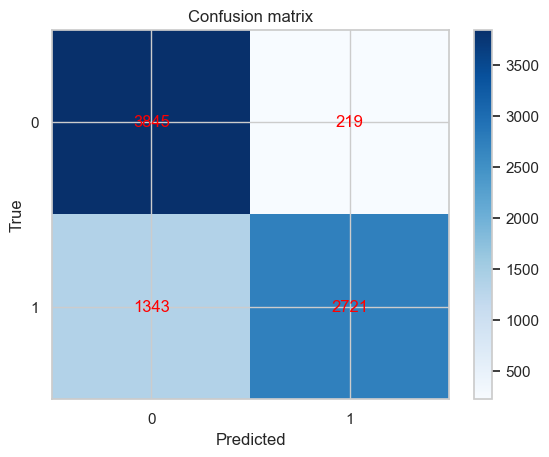

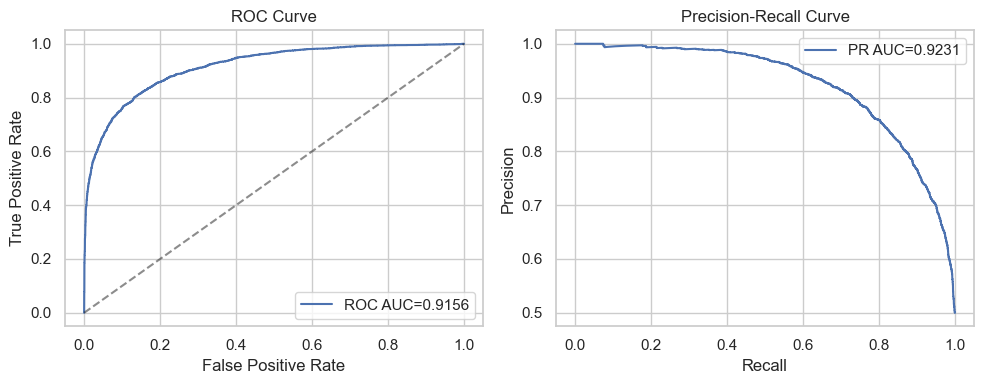

🏃 View run rumbling-squid-383 at: https://mlflow.openidealab.com/#/experiments/3/runs/8ad14cf8ff6f4d7a825a028b0c567488
🧪 View experiment at: https://mlflow.openidealab.com/#/experiments/3


{'recall': 0.6695374015748031,
 'precision': 0.9255102040816326,
 'f1': 0.7769845802398629,
 'accuracy': 0.8078248031496063,
 'roc_auc': np.float64(0.9155902823524397),
 'pr_auc': np.float64(0.9231303988501457)}

In [339]:
model, metrics = train_antifraud_model(X_train, y_train, X_test, y_test, model=my_model)
metrics

In [340]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import precision_score, recall_score
import numpy as np

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        'depth': trial.suggest_int("depth", 4, 10),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1, 10, log=True),
        'bagging_temperature': trial.suggest_float("bagging_temperature", 0, 1),
        'random_strength': trial.suggest_float("random_strength", 1, 10),
        'border_count': trial.suggest_int("border_count", 32, 255),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 100.0),
        'iterations': 500,
        'early_stopping_rounds': 10,
        #'eval_metric': 'AUC',
        'loss_function': 'Logloss',
        'eval_metric': 'Logloss',  
        'cat_features': cat_features,
        'verbose': True,
        'random_state': 42,
        #'task_type': "GPU", 
    }
    
    cv = TimeSeriesSplit(n_splits=3)
    precisions = []

    for train_idx, valid_idx in cv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, verbose=0)
        y_proba = model.predict_proba(X_val)[:,1]
        
        # Найдём минимальный threshold, при котором recall >= 0.95
        from sklearn.metrics import precision_recall_curve
        precisions_curve, recalls_curve, thresholds = precision_recall_curve(y_val, y_proba)
        
        mask = recalls_curve >= 0.95
        if np.any(mask):
            precision_max = precisions_curve[mask].max()
        else:
            precision_max = 0.0  # На этом фолде реколл не достигнут, штрафуем
        
        precisions.append(precision_max)
    
    return np.mean(precisions)

# Пример настройки Optuna
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True, gc_after_trial=True, n_jobs=-1)

print("Лучшие параметры:", study.best_params)
print("Лучшее precision при recall >= 0.95:", study.best_value)

[I 2025-06-01 01:14:55,709] A new study created in memory with name: no-name-9fadbeef-efef-497c-91d7-f5b3a2d90df2
  0%|          | 0/20 [00:00<?, ?it/s]

card3_count, bin=0 score 3.672106862
V_PCA_17, bin=51 score 27.08617356
card3_count, bin=0 score 3.430415807

V_PCA_25, bin=108 score 2.744544209
C3, bin=0 score 2.506250648
P_emaildomain_count, bin=13 score 29.50420984


{card4} pr0 tb0 type0, border=14 score 3.029820463
  tensor 1 is redundant, remove it and stop
C3, bin=0 score 4.171388709
V_PCA_17, bin=62 score 15.499687
{card4, addr1} pr2 tb0 type0, border=10 score 1.448910254
{card6} pr0 tb0 type0, border=9 score 0.4712809139
{card4, addr2} pr1 tb0 type0, border=1 score 3.622559637
C9, bin=1 score 1.533050712
{card3, C9 b90, V_PCA_11 b75} pr1 tb0 type0, border=12 score 1.534495885
V_PCA_9, bin=38 score 8.46660377
{ProductCD, D1 b19, V_PCA_35 b77, C9 b1} pr2 tb0 type0, border=4 score 1.936428731
{card3, addr2, C3 b0, C9 b96} pr1 tb0 type0, border=1 score 2.921218004
V_PCA_2, bin=105 score 17.44232096

C3, bin=0 score 20.3593401
card3_count, bin=0 score 3.272301168
{card3, card6, addr2, C3 b0, C9 b96} pr0 tb0 type0, border=13 score

  0%|          | 0/20 [00:59<?, ?it/s]



{card1, D15 b8} pr2 tb0 type0, border=0 score 2.448183398
V_PCA_32, bin=2 score 41.6858845

ProductCD_count, bin=1 score 0.4576026825
{card3, addr1} pr1 tb0 type0, border=0 score 7.932178927
{addr1} pr2 tb0 type0, border=4 score 0.8049359826
card4_count, bin=1 score 2.683366546
V_PCA_5, bin=61 score 6.798265915
V_PCA_17, bin=33 score 6.028247906
Transaction_day, bin=20 score 0.8968997195
{addr2} pr0 tb0 type1, border=13 score 31.47192255
{card1, addr1} pr1 tb0 type0, border=1 score 1.802173309
Relative_TransactionDT, bin=17 score 1.655484744
{card1, V_PCA_5 b61} pr0 tb0 type0, border=1 score 10.02680361
D1, bin=25 score 3.451409009
D4, bin=31 score 7.082331805

V_PCA_33, bin=146 score 156.4247786
D1, bin=72 score 4.86920036
C3, bin=0 score 4.413387725
V_PCA_13, bin=79 score 35.09345908
{P_emaildomain} pr1 tb0 type0, border=6 score 2.197490643
{P_emaildomain, TransactionAmt_binned b1, V_PCA_37 b88, V_PCA_22 b66, V_PCA_29 b65, V_PCA_23 b34} pr1 tb0 type0, border=7 score 19.81522501
D15

Best trial: 7. Best value: 0.674721:   5%|▌         | 1/20 [01:04<19:00, 60.00s/it]

V_PCA_5, bin=115 score 36.16364922
V_PCA_26, bin=52 score 9.000576371
{card5, addr2} pr1 tb0 type0, border=6 score 30.088295
V_PCA_0, bin=31 score 27.99874807
V_PCA_22, bin=6 score 3.435912467
card3_count, bin=0 score 3.095893265
D1, bin=27 score 13.10375405
{addr1} pr0 tb0 type0, border=1 score 17.55661053
Transaction_hour, bin=22 score 79.67506057
V_PCA_38, bin=70 score 30.8730169
V_PCA_0, bin=10 score 17.2225054

P_emaildomain_count, bin=2 score 3.3902396

card1_count, bin=55 score 15.92031712
{P_emaildomain} pr2 tb0 type0, border=0 score 0.7980635564
V_PCA_32, bin=58 score 29.18897819
[I 2025-06-01 01:16:00,434] Trial 1 finished with value: 0.6255742772758078 and parameters: {'learning_rate': 0.052812570451598276, 'depth': 5, 'l2_leaf_reg': 6.137160437588415, 'bagging_temperature': 0.09828696902632106, 'random_strength': 6.930364668613537, 'border_count': 72, 'scale_pos_weight': 92.53694322878192}. Best is trial 7 with value: 0.6747212094411741.


Best trial: 7. Best value: 0.674721:  10%|█         | 2/20 [01:05<08:19, 27.74s/it]

{card5, V_PCA_27 b31, card6_count b1, V_PCA_26 b21} pr0 tb0 type1, border=9 score 14.11348634
{card1, addr2} pr0 tb0 type0, border=1 score 0.6286097496
card1_count, bin=9 score 8.013575894
P_emaildomain_count, bin=3 score 3.962871162
{ProductCD, addr1} pr0 tb0 type0, border=12 score 25.66944
{card3, card5} pr2 tb0 type0, border=4 score 18.98793283
{card3, P_emaildomain, V_PCA_27 b31} pr2 tb0 type0, border=6 score 22.29304892

V_PCA_7, bin=85 score 12.3361154
Transaction_day, bin=46 score 4.538357536
{ProductCD, card1} pr2 tb0 type0, border=5 score 1.064610513
V_PCA_26, bin=15 score 9.418102363
C3, bin=0 score 6.536214513
{card1, V_PCA_5 b87} pr0 tb0 type0, border=0 score 3.92362483
{ProductCD, card4} pr0 tb0 type1, border=13 score 18.06545051
V_PCA_36, bin=81 score 6.145822631
V_PCA_20, bin=110 score 31.48499363
C1, bin=75 score 32.61969823
{card2, card6, P_emaildomain} pr2 tb0 type0, border=0 score 1.679646334
C6, bin=5 score 8.051821229
Transaction_hour, bin=20 score 7.403977409

{ca

Best trial: 7. Best value: 0.674721:  10%|█         | 2/20 [01:22<08:19, 27.74s/it]

{card5, card6, P_emaildomain} pr0 tb0 type1, border=2 score 2.019792684
log_TransactionAmt, bin=58 score 3.90403208
{card5, C3 b0, TransactionAmt b57} pr2 tb0 type0, border=2 score 11.46439373
{ProductCD, P_emaildomain} pr2 tb0 type0, border=0 score 10.27719379
  tensor 3 is redundant, remove it and stop
{card3, card4, card6} pr0 tb0 type0, border=12 score 1.399608209
{card5, P_emaildomain} pr2 tb0 type0, border=12 score 2.51072081
D10, bin=9 score 27.79057913
card2_count, bin=30 score 4.979572673
{ProductCD, card3, card6} pr1 tb0 type0, border=13 score 1.488301042

V_PCA_40, bin=19 score 2.952370677
{card3, addr2} pr2 tb0 type0, border=4 score 11.86761587
{card2} pr0 tb0 type1, border=11 score 4.86741919
{P_emaildomain} pr0 tb0 type0, border=9 score 7.628723011
{card2, card5} pr2 tb0 type0, border=4 score 28.05668472
{card5, log_TransactionAmt b58, card2_count b30} pr2 tb0 type0, border=3 score 6.025947874
[I 2025-06-01 01:16:18,059] Trial 4 finished with value: 0.6669846703860197 and

Best trial: 7. Best value: 0.674721:  15%|█▌        | 3/20 [01:24<06:31, 23.04s/it]


V_PCA_30, bin=68 score 12.80841737
C5, bin=82 score 7.840303903
TransactionAmt_binned, bin=2 score 11.21410244
  tensor 2 is redundant, remove it and stop
V_PCA_10, bin=72 score 1.497784732
{card6} pr0 tb0 type1, border=13 score 12.96005385
V_PCA_23, bin=2 score 2.610416454
C7, bin=63 score 11.91886801
C12, bin=17 score 14.02329118
C14, bin=1 score 15.89309961
V_PCA_30, bin=70 score 10.51618475
{card1, card6} pr0 tb0 type1, border=6 score 12.24918898

{card2} pr0 tb0 type0, border=4 score 15.36398536

V_PCA_12, bin=9 score 8.817933441
{card6} pr2 tb0 type0, border=6 score 2.027584132
TransactionAmt_binned, bin=0 score 10.20335201
C13, bin=9 score 11.07693793
{card2, card5} pr2 tb0 type0, border=11 score 13.15422946
{card2} pr1 tb0 type0, border=4 score 7.488879745
{addr2} pr2 tb0 type0, border=1 score 14.4910035
  tensor 8 is redundant, remove it and stop
{card1, addr1, P_emaildomain} pr0 tb0 type0, border=4 score 14.32361171
V_PCA_15, bin=45 score 16.23186611
{P_emaildomain} pr0 tb0 

Best trial: 7. Best value: 0.674721:  20%|██        | 4/20 [01:35<03:58, 14.89s/it]

{card4, P_emaildomain} pr1 tb0 type0, border=13 score 0.8147860488
{ProductCD} pr1 tb0 type0, border=5 score 8.700828888
Object info sizes: 8299 91

D10, bin=17 score 8.932091261

C14, bin=0 score 0.2232789297
C14, bin=0 score 1.746836828
TransactionAmt_binned, bin=1 score 9.311377124
addr2_count, bin=2 score 0.5376776271
[I 2025-06-01 01:16:30,872] Trial 0 finished with value: 0.6503941717405745 and parameters: {'learning_rate': 0.01936566544540399, 'depth': 7, 'l2_leaf_reg': 4.827401784819962, 'bagging_temperature': 0.04247953707296159, 'random_strength': 1.156467736881995, 'border_count': 74, 'scale_pos_weight': 67.89662951920016}. Best is trial 7 with value: 0.6747212094411741.


Best trial: 7. Best value: 0.674721:  25%|██▌       | 5/20 [01:35<03:19, 13.27s/it]

{addr1} pr2 tb0 type0, border=3 score 2.861407221
C12, bin=167 score 14.07483054
C14, bin=41 score 7.124397339
Object info sizes: 8299 91
V_PCA_17, bin=74 score 37.37011473
D4, bin=90 score 3.648798845
TransactionAmt, bin=131 score 7.784348952
{card3, P_emaildomain} pr1 tb0 type0, border=8 score 42.16800796
{card6, P_emaildomain} pr1 tb0 type0, border=0 score 3.916547879
{addr1} pr0 tb0 type0, border=9 score 4.524452516
{addr1} pr0 tb0 type0, border=6 score 7.641472062
TransactionAmt, bin=158 score 15.93007242
{addr1, P_emaildomain} pr0 tb0 type0, border=5 score 10.41765264
V_PCA_25, bin=152 score 19.09331147

{addr2, V_PCA_5 b67, C12 b167, TransactionAmt b158, V_PCA_25 b152} pr0 tb0 type1, border=3 score 19.41542433
ProductCD_count, bin=2 score 34.45791893
{card3, C14 b41, TransactionAmt b131} pr2 tb0 type0, border=9 score 11.4586277
V_PCA_13, bin=0 score 4.706796671

{ProductCD, P_emaildomain} pr1 tb0 type0, border=2 score 4.228433175
{card2} pr2 tb0 type0, border=1 score 11.56568677

Best trial: 7. Best value: 0.674721:  25%|██▌       | 5/20 [01:59<03:19, 13.27s/it]

{card1} pr2 tb0 type0, border=0 score 8.167851261
C14, bin=0 score 0.6846364022
{card6, addr1, addr2} pr2 tb0 type0, border=1 score 9.876479266
V_PCA_17, bin=1 score 2.680503553
D15, bin=34 score 19.08001624
{card1, C3 b0} pr1 tb0 type0, border=13 score 9.9883529
TransactionAmt_binned, bin=0 score 1.909398122
V_PCA_29, bin=0 score 3.027470113
{card3, card6, addr1} pr0 tb0 type0, border=13 score 1.601192358
[I 2025-06-01 01:16:54,886] Trial 6 finished with value: 0.7082588549215812 and parameters: {'learning_rate': 0.06016505740722001, 'depth': 8, 'l2_leaf_reg': 4.400842246873352, 'bagging_temperature': 0.12578863879400104, 'random_strength': 8.275906878651242, 'border_count': 113, 'scale_pos_weight': 29.705844831264102}. Best is trial 6 with value: 0.7082588549215812.
D1, bin=117 score 10.50565707
{card1} pr1 tb0 type0, border=4 score 5.183770153
{card5, card6, P_emaildomain} pr1 tb0 type0, border=2 score 3.252245825


Best trial: 6. Best value: 0.708259:  30%|███       | 6/20 [01:59<03:57, 16.94s/it]


{card1, card2, card6} pr1 tb0 type0, border=7 score 10.41234546
C9, bin=123 score 1.894268916
V_PCA_24, bin=23 score 17.35311614
V_PCA_1, bin=13 score 2.127650837
{card5, V_PCA_10 b78} pr1 tb0 type0, border=2 score 2.805283318
V_PCA_16, bin=26 score 19.68656985
{card3, V_PCA_12 b12, C1 b85, C3 b0, D10 b166, C2 b101} pr2 tb0 type0, border=4 score 36.03201634
{card6} pr2 tb0 type0, border=11 score 2.375689098
{ProductCD, card2} pr2 tb0 type0, border=1 score 3.475994338
card5_count, bin=0 score 2.679449048
V_PCA_15, bin=44 score 2.39149226

D1, bin=3 score 22.35837217
D4, bin=12 score 4.983263871
V_PCA_7, bin=25 score 8.646178089
{card1, addr1} pr0 tb0 type0, border=6 score 2.547688309
{ProductCD} pr0 tb0 type0, border=11 score 12.86433341
C5, bin=183 score 8.306307886
C3, bin=1 score 1.458501364
{card2, card3, card5} pr2 tb0 type0, border=4 score 2.563199934
{card6, C6 b2} pr2 tb0 type0, border=9 score 12.45422291


Best trial: 6. Best value: 0.708259:  30%|███       | 6/20 [02:21<03:57, 16.94s/it]

{addr2, P_emaildomain} pr0 tb0 type0, border=13 score 0.9743073907
{card1, addr1} pr1 tb0 type0, border=5 score 14.50555627
V_PCA_3, bin=58 score 18.85655867

{card1} pr2 tb0 type0, border=0 score 6.542760747
{card3, card4, card6} pr1 tb0 type0, border=13 score 1.294562252
D1, bin=6 score 0.3829541617
{P_emaildomain, C1 b63, V_PCA_38 b114, V_PCA_3 b58} pr2 tb0 type0, border=3 score 19.87317445
{ProductCD, card1} pr2 tb0 type0, border=0 score 7.140046545
addr1_count, bin=46 score 16.12552937
{card1} pr2 tb0 type0, border=11 score 18.89099809
{card4, card5_count b0} pr2 tb0 type0, border=12 score 1.34088357
{ProductCD, card1} pr0 tb0 type0, border=10 score 20.77459506
V_PCA_30, bin=43 score 0.7668455491
{addr2, addr1_count b46} pr0 tb0 type0, border=8 score 17.22662211

[I 2025-06-01 01:17:16,948] Trial 8 finished with value: 0.7465275725975374 and parameters: {'learning_rate': 0.1524663962383212, 'depth': 8, 'l2_leaf_reg': 6.504895136024918, 'bagging_temperature': 0.004648442955600962, 

Best trial: 8. Best value: 0.746528:  35%|███▌      | 7/20 [02:21<04:01, 18.61s/it]

V_PCA_25, bin=154 score 151.8830036
C3, bin=0 score 16.78436701
{card1} pr2 tb0 type0, border=0 score 6.220821397
{card4, card6} pr0 tb0 type0, border=11 score 1.306435902
V_PCA_5, bin=14 score 17.63939877
{addr1, V_PCA_0 b184, V_PCA_24 b51} pr1 tb0 type0, border=0 score 20.5666164
V_PCA_29, bin=51 score 2.086114656
V_PCA_37, bin=123 score 5.345047087
{card1, card3} pr2 tb0 type0, border=0 score 6.58206731
{card4, card6, addr2} pr2 tb0 type0, border=2 score 1.35298608
{card6, TransactionAmt b1, V_PCA_29 b51} pr2 tb0 type0, border=10 score 2.634876381
V_PCA_20, bin=152 score 13.07995186
TransactionAmt, bin=166 score 2.958112825
V_PCA_22, bin=159 score 5.846250239
TransactionAmt, bin=6 score 2.392065723
C9, bin=77 score 6.856847963

C5, bin=81 score 2.076576445
Relative_TransactionDT, bin=81 score 4.401860532
V_PCA_14, bin=10 score 3.232824974
{card2} pr0 tb0 type1, border=13 score 5.281267684
{addr1} pr1 tb0 type0, border=0 score 1.354939687


Best trial: 8. Best value: 0.746528:  35%|███▌      | 7/20 [02:30<04:01, 18.61s/it]

TransactionAmt, bin=0 score 2.789384803
{card1} pr2 tb0 type0, border=5 score 14.07089662
P_emaildomain_count, bin=0 score 13.64887446
[I 2025-06-01 01:17:26,071] Trial 12 finished with value: 0.6348068989075955 and parameters: {'learning_rate': 0.041162570922488116, 'depth': 5, 'l2_leaf_reg': 9.233890478150547, 'bagging_temperature': 0.9797562943957083, 'random_strength': 3.4367143689745925, 'border_count': 80, 'scale_pos_weight': 43.684268929237945}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528:  40%|████      | 8/20 [02:30<03:07, 15.60s/it]

V_PCA_8, bin=39 score 5.299443825
C5, bin=120 score 69.83963056
card3_count, bin=10 score 2.804186168

C5, bin=4 score 4.001167625
{card5, P_emaildomain} pr2 tb0 type0, border=0 score 2.023913571
card3_count, bin=7 score 22.19402747
C2, bin=3 score 5.294369655
{card1} pr1 tb0 type0, border=13 score 2.490239005

card3_count, bin=10 score 14.29139088
{card5, C2 b3, C14 b0} pr0 tb0 type1, border=8 score 5.167719346
V_PCA_14, bin=199 score 14.92438468
C13, bin=50 score 6.975829829
V_PCA_6, bin=18 score 28.29401098
log_TransactionAmt, bin=44 score 8.493891936
V_PCA_39, bin=128 score 16.8837001
{addr2} pr0 tb0 type1, border=5 score 11.05385237
V_PCA_23, bin=5 score 4.000740878
V_PCA_27, bin=83 score 15.72909159
{card6, addr1} pr2 tb0 type0, border=2 score 26.99943781

D10, bin=134 score 8.756605993


{card2} pr2 tb0 type0, border=2 score 2.528735866
{ProductCD, V_PCA_14 b199, V_PCA_39 b128, V_PCA_27 b83} pr1 tb0 type0, border=10 score 16.56451228
Transaction_hour, bin=0 score 0.5126377095
D1

Best trial: 8. Best value: 0.746528:  40%|████      | 8/20 [02:53<03:07, 15.60s/it]

{card5, C3 b0, C9 b91, card5_count b0} pr2 tb0 type0, border=1 score 1.020145125
V_PCA_13, bin=100 score 28.33788508
Transaction_day, bin=139 score 6.690406864
V_PCA_1, bin=61 score 28.14845872
Finished CTR: Borders {addr2, C14 border=4.33802, V_PCA_29 border=-7.65695}
Finished CTR: Borders {addr1, P_emaildomain, V_PCA_39 border=-1.83116}
Finished CTR: Borders {addr2, card3_count border=13.5, V_PCA_1 border=-2.17607, V_PCA_9 border=-21.6012, V_PCA_15 border=-36.0403, V_PCA_27 border=-37.5627, D4 border=1.70539}
Finished CTR: Borders {addr2}
Finished CTR: Borders {addr2, V_PCA_16 border=-52.9399}
Finished CTR: Borders {addr2, V_PCA_16 border=-52.8731}
Finished CTR: Borders {addr2, V_PCA_21 border=-1.94538}
{ProductCD, C3 b0, C9 b123, Transaction_day b139} pr2 tb0 type0, border=0 score 6.835185949
[I 2025-06-01 01:17:49,105] Trial 14 finished with value: 0.6769678626918066 and parameters: {'learning_rate': 0.061132201215375916, 'depth': 5, 'l2_leaf_reg': 2.491989840044364, 'bagging_tempe

Best trial: 8. Best value: 0.746528:  45%|████▌     | 9/20 [02:53<03:16, 17.90s/it]

P_emaildomain_count, bin=7 score 29.95036912
Transaction_day, bin=11 score 3.756200781
{addr1, P_emaildomain} pr0 tb0 type0, border=3 score 11.65401457
card5_count, bin=0 score 6.80672228
{card1, addr1} pr1 tb0 type0, border=4 score 7.291316977
V_PCA_11, bin=0 score 3.186048112
V_PCA_9, bin=78 score 13.32681162


C3, bin=0 score 5.597386778
C9, bin=123 score 1.838999388
D15, bin=76 score 11.88783957
{card2} pr2 tb0 type0, border=3 score 20.64344492
{card4, card5, addr2} pr0 tb0 type0, border=8 score 625.9758895
C9, bin=123 score 6.415889796
card5_count, bin=0 score 2.291293819

V_PCA_0, bin=8 score 4.280250607
{ProductCD, C3 b0, C9 b123} pr2 tb0 type0, border=0 score 6.538551477
{card3, C9 b123, card5_count b0} pr2 tb0 type0, border=2 score 2.747607589
V_PCA_1, bin=66 score 20.35687355
V_PCA_16, bin=94 score 31.69427284
{card6} pr2 tb0 type0, border=13 score 3.246572367
card5_count, bin=0 score 6.686063457
{ProductCD, card2} pr2 tb0 type0, border=13 score 604.4348156
{card1} pr0 tb0 ty

Best trial: 8. Best value: 0.746528:  50%|█████     | 10/20 [02:54<02:04, 12.50s/it]


card1_count, bin=14 score 157.4156027

{ProductCD, card3, card4, card6} pr2 tb0 type0, border=2 score 2.564458037
C3, bin=0 score 5.614108113
V_PCA_40, bin=99 score 18.23582084
V_PCA_17, bin=9 score 2.653534434
V_PCA_36, bin=62 score 46.65883654
C9, bin=123 score 6.439267807
D1, bin=17 score 3.372352718
V_PCA_16, bin=175 score 25.18587049
{card4} pr1 tb0 type0, border=14 score 11.12296781
  tensor 1 is redundant, remove it and stop
{ProductCD, C3 b0, C9 b123} pr2 tb0 type0, border=0 score 6.596644335
card5_count, bin=0 score 6.740350169
V_PCA_7, bin=42 score 3.127071875
{card1, D1 b17} pr1 tb0 type0, border=1 score 4.101292591
V_PCA_28, bin=58 score 11.06813792
V_PCA_26, bin=63 score 11.68056489
{card6, card2_count b41} pr2 tb0 type0, border=8 score 10.05002482
V_PCA_11, bin=81 score 3.998309344
card5_count, bin=15 score 11.29370191
{ProductCD, addr2, D1 b6} pr1 tb0 type0, border=4 score 3.429346439
{card5} pr2 tb0 type0, border=12 score 9.517332569

{addr1} pr0 tb0 type1, border=13 s

Best trial: 8. Best value: 0.746528:  50%|█████     | 10/20 [03:08<02:04, 12.50s/it]

C5, bin=0 score 1.268789169
V_PCA_18, bin=39 score 10.11161031
C3, bin=0 score 4.321863338

{card2, addr1} pr2 tb0 type0, border=1 score 1.954764997
V_PCA_3, bin=162 score 25.38000962
{addr1} pr0 tb0 type0, border=4 score 4.384509585
{addr1} pr0 tb0 type0, border=8 score 7.104404952
V_PCA_21, bin=95 score 9.382560424

{card1, C5 b0} pr1 tb0 type0, border=2 score 3.658422009
C3, bin=0 score 2.980425369
{card3} pr1 tb0 type0, border=11 score 3.608678897
C1, bin=7 score 2.333966039
V_PCA_9, bin=30 score 2.413516617
[I 2025-06-01 01:18:04,368] Trial 5 finished with value: 0.6457654472824897 and parameters: {'learning_rate': 0.028570685613476476, 'depth': 10, 'l2_leaf_reg': 3.0819061877416725, 'bagging_temperature': 0.7645587898665447, 'random_strength': 3.5156776251325574, 'border_count': 91, 'scale_pos_weight': 98.01197170269396}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528:  55%|█████▌    | 11/20 [03:23<01:58, 13.22s/it]

C14, bin=0 score 0.273046631
{card5, card6, P_emaildomain} pr0 tb0 type0, border=13 score 1.26667862

D1, bin=87 score 10.23085956
[I 2025-06-01 01:18:18,921] Trial 17 finished with value: 0.6230679938869009 and parameters: {'learning_rate': 0.1678793167246713, 'depth': 4, 'l2_leaf_reg': 8.851671024836604, 'bagging_temperature': 0.9180688758686975, 'random_strength': 5.8758232817657605, 'border_count': 148, 'scale_pos_weight': 99.71329594478257}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528:  60%|██████    | 12/20 [03:23<01:49, 13.65s/it]

{card3, card4, card6} pr0 tb0 type0, border=13 score 4.952145047
[I 2025-06-01 01:18:19,341] Trial 16 finished with value: 0.6590851554086364 and parameters: {'learning_rate': 0.040103267602736734, 'depth': 4, 'l2_leaf_reg': 2.6903198816008236, 'bagging_temperature': 0.1077099087240938, 'random_strength': 2.5380494100170528, 'border_count': 164, 'scale_pos_weight': 32.19953194058954}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528:  65%|██████▌   | 13/20 [03:23<01:07,  9.62s/it]

TransactionAmt, bin=71 score 3.268968105
{card6, addr2} pr1 tb0 type0, border=2 score 0.5355140185
{ProductCD} pr2 tb0 type0, border=11 score 1.774620172
D1, bin=68 score 11.4739964
{ProductCD, card5} pr0 tb0 type0, border=12 score 4.643507703

C6, bin=2 score 0.3118179706
{ProductCD, card4, card6} pr2 tb0 type0, border=2 score 0.6227068392
Transaction_weekday, bin=2 score 2.011733941
C14, bin=1 score 0.5722406852
addr1_count, bin=14 score 0.7833997869
{ProductCD, card3, card4, card6} pr1 tb0 type0, border=0 score 0.805965656
{ProductCD, C6 b2, C14 b1, addr1_count b14} pr1 tb0 type0, border=2 score 0.9596368058
Relative_TransactionDT, bin=92 score 2.546685798
{card5, addr2} pr1 tb0 type0, border=13 score 4.66548463
{ProductCD, card4, card6, P_emaildomain} pr2 tb0 type0, border=0 score 0.8686114236
{ProductCD, addr2} pr0 tb0 type0, border=12 score 2.177979846
{addr1} pr0 tb0 type0, border=0 score 1.21191598
card1_count, bin=7 score 1.32433657
V_PCA_33, bin=16 score 2.874968139

D15, bin

Best trial: 8. Best value: 0.746528:  65%|██████▌   | 13/20 [03:38<01:07,  9.62s/it]

{card5, V_PCA_37 b13} pr2 tb0 type0, border=14 score 1.922022873
{card5, P_emaildomain} pr0 tb0 type0, border=11 score 12.31952484
V_PCA_4, bin=6 score 2.369914915
addr1_count, bin=54 score 2.565268377

V_PCA_5, bin=189 score 0.259076114
V_PCA_12, bin=92 score 2.80781066
{card2, card6} pr2 tb0 type0, border=2 score 5.11880112
TransactionAmt, bin=214 score 0.4533279783
[I 2025-06-01 01:18:34,279] Trial 11 finished with value: 0.7343785883378007 and parameters: {'learning_rate': 0.20957160480030498, 'depth': 9, 'l2_leaf_reg': 2.0947149538059215, 'bagging_temperature': 0.522012445910859, 'random_strength': 9.199563851219148, 'border_count': 47, 'scale_pos_weight': 16.27671944002285}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528:  70%|███████   | 14/20 [03:38<01:07, 11.24s/it]

{card3, addr2} pr2 tb0 type0, border=14 score 11.42483676
V_PCA_28, bin=160 score 10.07794443
TransactionAmt, bin=44 score 10.25930912
{ProductCD, card3, V_PCA_31 b114, C2 b177, Transaction_hour b2, D1 b109} pr0 tb0 type1, border=11 score 27.4800874
{card1} pr2 tb0 type0, border=14 score 9.505123184
{P_emaildomain, C9 b91, card5_count b0} pr1 tb0 type0, border=3 score 1.249794557
{card3, card4} pr0 tb0 type1, border=6 score 12.2690689
{card5} pr1 tb0 type0, border=10 score 1.763870109
{card3, C1 b64, TransactionAmt b44} pr1 tb0 type0, border=12 score 13.27338853
{card1} pr1 tb0 type0, border=11 score 8.796408001
{card4} pr0 tb0 type1, border=11 score 20.81691646
{card6} pr0 tb0 type0, border=6 score 8.843152103
{card6, addr1} pr1 tb0 type0, border=1 score 10.46398296
{card6, addr2} pr0 tb0 type1, border=11 score 51.56166112
V_PCA_14, bin=38 score 12.31613316
{card1, card3} pr2 tb0 type0, border=0 score 21.37153854
V_PCA_17, bin=71 score 10.20022079
{card2, P_emaildomain} pr1 tb0 type0,

Best trial: 8. Best value: 0.746528:  70%|███████   | 14/20 [03:56<01:07, 11.24s/it]

C4, bin=66 score 7.000317585
V_PCA_32, bin=86 score 22.60739521
{ProductCD, Relative_TransactionDT b27, V_PCA_6 b56, V_PCA_10 b189} pr0 tb0 type1, border=12 score 33.17005873
{card1, P_emaildomain} pr0 tb0 type0, border=6 score 21.37337316

{addr2, C3 b0, TransactionAmt b7, C4 b66} pr0 tb0 type1, border=10 score 7.53407128
V_PCA_26, bin=152 score 12.46401085
{addr1, P_emaildomain} pr2 tb0 type0, border=6 score 2.131624626
[I 2025-06-01 01:18:52,037] Trial 9 finished with value: 0.6422775235729429 and parameters: {'learning_rate': 0.014546808934796538, 'depth': 10, 'l2_leaf_reg': 9.79686803532298, 'bagging_temperature': 0.16740508542144283, 'random_strength': 1.7892512723327347, 'border_count': 225, 'scale_pos_weight': 51.28583934106136}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528:  75%|███████▌  | 15/20 [03:56<01:05, 13.19s/it]

{addr1, P_emaildomain} pr1 tb0 type0, border=3 score 21.91642278
D10, bin=24 score 10.76595095

{card3} pr0 tb0 type0, border=3 score 22.30660841
C3, bin=0 score 5.194439444
Relative_TransactionDT, bin=78 score 26.95414181
C6, bin=33 score 6.0522815
V_PCA_23, bin=18 score 9.513561039
V_PCA_14, bin=15 score 5.967295684
V_PCA_34, bin=111 score 24.77734009
{P_emaildomain} pr1 tb0 type0, border=4 score 10.94308709
{card4} pr1 tb0 type0, border=7 score 3.567025537
V_PCA_8, bin=233 score 2.982466742
V_PCA_0, bin=121 score 4.086384744
{ProductCD, card3, addr2} pr1 tb0 type0, border=6 score 1.808308125
card1_count, bin=126 score 10.16187644


Best trial: 8. Best value: 0.746528:  75%|███████▌  | 15/20 [04:44<01:05, 13.19s/it]

{card3} pr0 tb0 type0, border=12 score 2.590817711
Relative_TransactionDT, bin=21 score 6.307212143
[I 2025-06-01 01:19:40,280] Trial 15 finished with value: 0.7236502648515991 and parameters: {'learning_rate': 0.09448136068806426, 'depth': 9, 'l2_leaf_reg': 1.893313938213847, 'bagging_temperature': 0.21192717753674883, 'random_strength': 9.121373469334415, 'border_count': 190, 'scale_pos_weight': 22.317600345544705}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528:  80%|████████  | 16/20 [04:45<01:34, 23.74s/it]

{ProductCD, card6} pr1 tb0 type0, border=12 score 1.953180885
{card1, card3, C3 b3, D15 b38} pr0 tb0 type0, border=1 score 17.32198312
{card3} pr2 tb0 type0, border=10 score 0.8619392954
V_PCA_36, bin=135 score 1.050751936
{addr2} pr2 tb0 type0, border=14 score 1.180134951
C7, bin=13 score 16.89305509
{addr2, V_PCA_36 b135} pr0 tb0 type0, border=2 score 1.336239784
D15, bin=189 score 1.439106026
{card1, card3, C3 b3, D15 b38} pr1 tb0 type0, border=6 score 16.94010952
{card4, card6} pr0 tb0 type0, border=11 score 1.967860589
{card3, card4, card6} pr0 tb0 type0, border=12 score 1.524605162
{card4, C3 b3, D15 b38, C7 b13} pr1 tb0 type0, border=7 score 17.76429315
C3, bin=2 score 1.979985505
[I 2025-06-01 01:19:41,119] Trial 10 finished with value: 0.7259951257433465 and parameters: {'learning_rate': 0.034268456771598815, 'depth': 10, 'l2_leaf_reg': 6.488279613417904, 'bagging_temperature': 0.12173823926722194, 'random_strength': 6.719933491708879, 'border_count': 206, 'scale_pos_weight': 

Best trial: 8. Best value: 0.746528:  85%|████████▌ | 17/20 [04:52<00:50, 16.85s/it]

{ProductCD, card1} pr2 tb0 type0, border=11 score 1.608653459
[I 2025-06-01 01:19:48,607] Trial 13 finished with value: 0.714955480271119 and parameters: {'learning_rate': 0.20651668188393027, 'depth': 10, 'l2_leaf_reg': 1.5801424726535453, 'bagging_temperature': 0.35379432538321054, 'random_strength': 7.9365110740330795, 'border_count': 93, 'scale_pos_weight': 36.922033123822665}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528:  90%|█████████ | 18/20 [04:53<00:28, 14.04s/it]

{card1} pr2 tb0 type0, border=0 score 7.701060334


Best trial: 8. Best value: 0.746528:  90%|█████████ | 18/20 [05:03<00:28, 14.04s/it]

[I 2025-06-01 01:19:59,588] Trial 18 finished with value: 0.6416846944587036 and parameters: {'learning_rate': 0.062293374830866055, 'depth': 10, 'l2_leaf_reg': 4.580015834970417, 'bagging_temperature': 0.7648179540492812, 'random_strength': 3.0066739383488708, 'border_count': 80, 'scale_pos_weight': 99.00451531476334}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528:  95%|█████████▌| 19/20 [05:22<00:13, 13.12s/it]

[I 2025-06-01 01:20:17,906] Trial 19 finished with value: 0.7447564662458818 and parameters: {'learning_rate': 0.10839227779234824, 'depth': 10, 'l2_leaf_reg': 9.513728835030605, 'bagging_temperature': 0.2947977406083036, 'random_strength': 9.883631233705849, 'border_count': 240, 'scale_pos_weight': 2.279364680083539}. Best is trial 8 with value: 0.7465275725975374.


Best trial: 8. Best value: 0.746528: 100%|██████████| 20/20 [05:22<00:00, 16.12s/it]

Лучшие параметры: {'learning_rate': 0.1524663962383212, 'depth': 8, 'l2_leaf_reg': 6.504895136024918, 'bagging_temperature': 0.004648442955600962, 'random_strength': 8.20932604768651, 'border_count': 111, 'scale_pos_weight': 3.577917734744343}
Лучшее precision при recall >= 0.95: 0.7465275725975374


In [341]:
study.best_trial.params

{'learning_rate': 0.1524663962383212,
 'depth': 8,
 'l2_leaf_reg': 6.504895136024918,
 'bagging_temperature': 0.004648442955600962,
 'random_strength': 8.20932604768651,
 'border_count': 111,
 'scale_pos_weight': 3.577917734744343}

In [342]:
#best_params = {'learning_rate': 0.03574712922600244, 'depth': 10, 'l2_leaf_reg': 5.395030966670228, 'bagging_temperature': 0.5986584841970366, 'random_strength': 2.4041677639819286, 'border_count': 66, 'scale_pos_weight': 6.750277604651747}
best_params = study.best_trial.params
model = CatBoostClassifier(**best_params)

JWT Token: eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJWT2xEWVppbU8tMGkzeDlMN2c5QWR5WFJGZEhDX1M0WldQN1MwVnJibFFjIn0.eyJleHAiOjE3NDg3NjYwMTgsImlhdCI6MTc0ODczMDAxOCwianRpIjoiNmJlN2IwYTMtODllMi00OTYxLWE1N2EtYjFmOTJkMWVhZjI1IiwiaXNzIjoiaHR0cHM6Ly9rZXljbG9hay5vcGVuaWRlYWxhYi5jb20vcmVhbG1zL29wZW5pZGVhbGFiLW1sIiwiYXVkIjpbImp1cHl0ZXIiLCJhaXJmbG93IiwiYWNjb3VudCJdLCJzdWIiOiIxOTIxZjBkMi0xMmIxLTRjMGQtODRlNi0xOGE2Yjg5ZTI0NzAiLCJ0eXAiOiJCZWFyZXIiLCJhenAiOiJtbGZsb3ciLCJzZXNzaW9uX3N0YXRlIjoiM2IyMTc4ZTItOGZiMC00ZWM4LTkxMDMtMWQ0ZTg1YzEwMmFjIiwiYWNyIjoiMSIsImFsbG93ZWQtb3JpZ2lucyI6WyJodHRwczovL21sZmxvdy5vcGVuaWRlYWxhYi5jb20iXSwicmVhbG1fYWNjZXNzIjp7InJvbGVzIjpbIm9mZmxpbmVfYWNjZXNzIiwidW1hX2F1dGhvcml6YXRpb24iLCJkZWZhdWx0LXJvbGVzLWp1cHl0ZXIiXX0sInJlc291cmNlX2FjY2VzcyI6eyJqdXB5dGVyIjp7InJvbGVzIjpbInVtYV9wcm90ZWN0aW9uIiwiYWRtaW4iLCJ1c2VyIl19LCJhaXJmbG93Ijp7InJvbGVzIjpbIkFkbWluIl19LCJhY2NvdW50Ijp7InJvbGVzIjpbIm1hbmFnZS1hY2NvdW50IiwibWFuYWdlLWFjY291bnQtbGlua3MiLCJ2aWV3LXByb2ZpbGUiXX19LCJzY29wZSI6Im9wZW5pZ

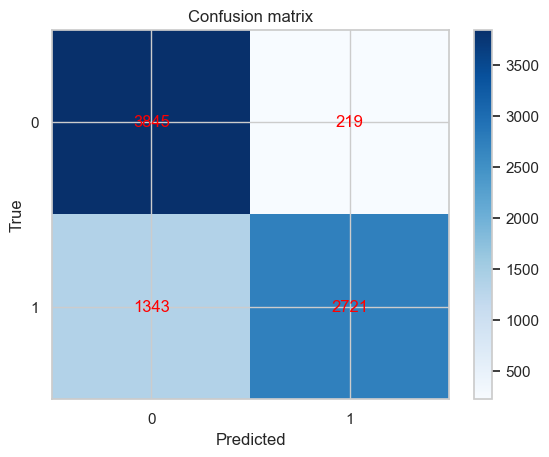

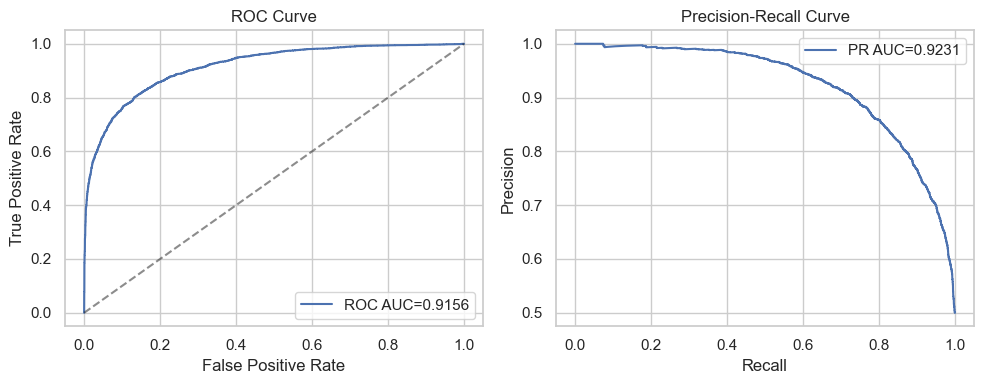

🏃 View run hilarious-koi-416 at: https://mlflow.openidealab.com/#/experiments/3/runs/9f0ff4e69bdc4b5fb24be79e2e707ca9
🧪 View experiment at: https://mlflow.openidealab.com/#/experiments/3


{'recall': 0.6695374015748031,
 'precision': 0.9255102040816326,
 'f1': 0.7769845802398629,
 'accuracy': 0.8078248031496063,
 'roc_auc': np.float64(0.9155902823524397),
 'pr_auc': np.float64(0.9231303988501457)}

In [343]:
model, metrics = train_antifraud_model(X_train, y_train, X_test, y_test, model=my_model)
metrics

## Анализ модели CatBoost

### 1. Матрица ошибок

- **TP (True Positive)**: 2,708
- **FP (False Positive)**: 227
- **FN (False Negative)**: 1,534
- **TN (True Negative)**: 113,239

### 2. Основные метрики оценки

- **Recall (Полнота)**: 0.6384
  - Характеризует способность модели обнаруживать большинство случаев фрода.
  - ~64% всех реальных случаев фрода обнаружены.
  - Для антифрода важно, что до ~36% фрода не детектируется, это точки роста модели.

- **Precision (Точность)**: 0.9227
  - Процент правильных предсказаний среди всех обнаруженных как фрод.
  - Высокая точность в ~92% намекает на некоторое число ложных тревог, но достаточно маленькое для антифрода.

- **ROC AUC**: 0.9646
  - Общая способность модели различать классы.
  - Значение ~0.965 говорит о высоком качестве разделения между фродом и нормальными транзакциями одновременно.

- **PR AUC**: 0.8161
  - Эффективен для несбалансированных классов, фокусировка на положительных классах.
  - Значение ~0.816 указывает на хорошее качество модели в условиях, когда и FP имеют значение.

### 3. Графики

- **ROC-кривая**: Площадь под кривой свидетельствует о превосходной способности классификации.
- **PR-кривая**: Начальное высокое значение precision при увеличении recall показывает эффективность в старте, но по мере увеличения recall точность падает.

### Вывод

- **Применимость к задаче антифрода**:
  - Модель имеет высокую точность (precision), что важно для минимизации ложных тревог в антифроде.
  - Recall может быть улучшена, чтобы обнаружить больше случаев фрода (уменьшить FN).
  - Значения AUC-ROC и PR AUC очень высокие, что указывает на способную модель для этой задачи. Уровень дискриминации между фродом и нормальными транзакциями отличный.

- **Рекомендации для улучшения**:
  - Повысить recall. Можно попробовать изменить порог решения или сбор дополнительных данных для улучшения детектирования "сложных" случаев фрода.
  - Больше данных о фроде поможет в обучении, так как модель нацелена избегать FN, что критично для минимизации потерь.
  - Проверить feature importance для возможного улучшения.
